<a href="https://colab.research.google.com/github/marcospaulofg/Data-Science/blob/main/Machine%20Learning%20%26%20Analytics/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introdução
---

- Objetivo:

O objetivo deste projeto é criar e avaliar um modelo de Deep Learning capaz de identificar e classificar diferentes tipos de frutas a partir de imagens. A ideia desse modelo é ser um protótipo de identificação de frutas em caixas de mercados.

- Descrição do problema:

A diversidade visual, como formas, tamanhos e cores variadas entre as frutas é um dos desafios da classificação de frutas por imagens. Além disso, frutas com características visuais semelhantes (por exemplo, maçã e pera) apresentam maior complexidade para serem diferenciadas. O modelo deve ser capaz de generalizar bem mesmo com essas dificuldades.

- Premissas:

As frutas são representadas de forma semelhante a bancada de um mercado nas imagens, jogadas e em um fundo de uma bandeja alumínio.
O dataset é variado para todas as frutas, para capturar a diversidade de cada uma delas e permitir o modelo a aprender suas características distintas.

- Condições:

  * Cada imagem tem apenas um tipo (classe) de fruta por vez;
  * As imagens podem ter mais de uma fruta, contanto que seja da mesma classe.

- Descrição do Dataset:

O dataset é composto por 1.000 imagens de frutas categorizadas em 15 classes: Apple, Banana, Carambola, Guava, Kiwi, Mango, Muskmelon, Orange, Peach, Pear, Persimmon, Pitaya, Plum, Pomegranet, Tamotoes. O rótulo das frutas estão no próprio nome do arquivo e em inglês. As imagens são coloridas. Como já mencionado anteriormente, as frutas estão em uma bandeja de alumínio e em diversas posições diferentes.

O dataset está ospedado no Google Drive, em um arquivo de extensão .tar, podendo ser acessado através do link público a seguir:

https://drive.google.com/file/d/1XvM8c_2PNzFSfglFlTLUL2MGhN0SnxFW/view?usp=sharing

# 2. Instalar e importar bibliotecas necessárias
---

In [ ]:
# Instalar bibliotecas necessárias

!pip install keras-tuner  # instala a biblioteca para fazer a busca de hiperparâmetros

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
# Importar bibliotecas necessárias

# Para o pré-processamento:
import random  # biblioteca para gerar números aleatórios
import os  # biblioteca para manipular arquivos/pastas/caminhos do sistema operacional
import numpy as np  # biblioteca para manipular números
import cv2  # biblioteca para processamento de imagens
from sklearn.model_selection import train_test_split  # para fazer o holdout dos dados (dividir entre conjunto de treino e teste)
from sklearn.preprocessing import OneHotEncoder  # para converter os rótulos para vetores binários

# Para o treinamento:
import tensorflow as tf
from tensorflow.keras.models import Sequential  # para cria um modelo que as camadas são empilhadas sequencialmente
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D  # para criar as camadas do modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # para aumentar o dataset com Data Augmentation
import keras_tuner as kt  # biblioteca para fazer a busca de hiperparâmetros
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # para parar o treinamento caso o modelo não melhore e salvar o modelo sempre que ele melhorar em relação à métrica monitorada
from tensorflow.keras.applications import ResNet50, DenseNet121  # para usar os modelos pré-treinados ResNet e DenseNet
from tensorflow.keras.optimizers import Adam  # para usar o otimizador Adam

# Para importar e exportar os modelos:
from google.colab import drive  # para salvar arquivos no Google Drive
import pickle  # para salvar o histórico dos modelos
from tensorflow.keras.models import load_model  # para carregar o modelo salvo

# Para a avaliação de resultados:
import matplotlib.pyplot as plt  # para plotar gráficos
import seaborn as sns  # para plotar a gráficos
from sklearn.metrics import confusion_matrix  # para plotar a matriz de confusão
from sklearn.metrics import classification_report  # para analisar as métricas precision, recall e f1-score

# 3. Preparação de Dados
---

## 3.1 - Configurar a Seed Global

Vamos configurar uma seed única para todas as bibliotecas usadas no projeto para garantir a reprodutibilidade, ou seja, independente do ambiente de reprodução, os resultados obtidos sejam sempre os mesmos.

In [ ]:
# Configurar a seed para reprodutibilidade
SEED = 42  # número fixo para a seed

# TensorFlow
tf.random.set_seed(SEED)

# NumPy
np.random.seed(SEED)

# Random (Python)
random.seed(SEED)

# Determinismo em operações multi-thread
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## 3.2 - Baixar e extrair o dataset

O dataset está hospedado em um link público do Google Drive. Nesse bloco de código iremos baixar e extrair esse dataset para uma pasta na máquina local do Google Colab.

In [ ]:
# Baixa o arquivo do google drive para o colab
!gdown --id 1XvM8c_2PNzFSfglFlTLUL2MGhN0SnxFW -O dataset.tar

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XvM8c_2PNzFSfglFlTLUL2MGhN0SnxFW
From (redirected): https://drive.google.com/uc?id=1XvM8c_2PNzFSfglFlTLUL2MGhN0SnxFW&confirm=t&uuid=22b215f0-3d58-4036-a40e-445dd1e09695
To: /content/dataset.tar
100% 133M/133M [00:03<00:00, 34.2MB/s]


In [ ]:
# Cria a pasta extracted_files para que todas as imagens do dataset sejam extraidas nela

extraction_path = '/content/extracted_files'
os.makedirs(extraction_path, exist_ok=True)

!tar -xf dataset.tar -C {extraction_path}

## 3.3 - Transformações e Pré-processamento dos Dados

Aplicaremos a normalização, redimensionamento e transformação para tensores dos dados e carregaremos as imagens e seus rótulos em listas chamadas "images" e "labels".

- A normalização será feita antes do holdout sem haver vazamento de dados, pois ela será realizada em cada imagem separadamente, e não através de estatísticas (como média e desvio padrão) do conjunto inteiro. Isso ocorrerá no momento que usarmos cv2.resize(img, (224, 224)) e depois img / 255.0.

- O redimensionamento para imagens 224x224 será escolhido pois corresponde ao tamanho esperado por muitas redes populares, como ResNet e DenseNet.

- A conversão para tensores não é necessária pois o formato de tensor já pode ser obtido diretamente após o redimensionamento, normalização e ao final da função retornando como array numpy.

Depois iremos rodar um bloco de código para imprimir na tela a quantidade de imagens que temos para cada classe.

In [ ]:
# Define o diretório de onde as imagens foram baixadas
dataset_dir = '/content/extracted_files'  # caminho do dataset

# Função para carregar as imagens
def load_images(dataset_dir):
    images = []  # cria uma lista vazia para armazenar as imagens
    labels = []  # cria uma lista vazia para armazenar o nome correspondente a cada imagem

    # Percorre os diretórios e carrega as imagens
    files = sorted(os.listdir(dataset_dir))  # Ordena os nomes de arquivos em ordem alfabética
    for arq in files:  # para cada arquivo no caminho do dataset faça:
      img_path = os.path.join(dataset_dir, arq)  # img_patch é o caminho completo de cada arquivo
      img = cv2.imread(img_path)  # lê cada imagem com o cv2
      img = cv2.resize(img, (224, 224))  # Redimensiona as imagens para 224x224
      img = img / 255.0  # Normaliza a imagem para a faixa [0, 1]
      images.append(img)  # adiciona cada imagem na lista imagens
      labels.append(arq.split(' ')[0])  # adiciona cada nome de arquivo na lista de labels

    return np.array(images), np.array(labels)

In [ ]:
# Carrega as imagens e rótulos
images, labels = load_images(dataset_dir)

In [ ]:
# Mostra quantos elementos temos em cada label

# Encontra os elementos únicos e suas contagens
unique_elements, counts = np.unique(labels, return_counts=True)

# Filtra elementos que são repetidos (contagem maior que 1)
repeated_elements = unique_elements[counts > 1]
repeated_counts = counts[counts > 1]

# Exibe os elementos repetidos e suas contagens
for element, count in zip(repeated_elements, repeated_counts):
    print(f"'{element}': {count}")

'Apple': 120
'Banana': 67
'Carambola': 44
'Guava': 78
'Kiwi': 97
'Mango': 99
'Muskmelon': 45
'Orange': 56
'Peach': 66
'Pear': 69
'Persimmon': 46
'Pitaya': 72
'Plum': 53
'Pomegranet': 40
'Tamotoes': 48


## 3.4 - Separar conjunto entre Treino, Teste e Validação

Primeiro iremos realizar um holdout com 70% para treino, 15% para validação e 15% para teste.

A estratificação garante que a todos os conjuntos sejam separados uniformemente, ajudando a evitar o desbalanceamento entre classes e melhorando a avaliação do modelo.

Em seguida iremos usar o OneHotEncoder() para codificar as labels para vetores binários. Essa codificação será compatível com a função de perda "categorical_crossentropy" que será usada futuramente durante o treino do modelo.

Depois iremos rodar dois blocos de código para:

1. conferir o shape das imagens (X) e de seus rótulos (y), e dizer quais são esses rótulos;
2. imprimir na tela a quantidade de imagens que foram separadas para treino, validação e teste.

In [ ]:
# Separar Conjunto entre Treino, Teste e Validação

X_train, X_temp, y_train, y_temp = train_test_split(images,
                                                    labels,
                                                    test_size=0.3,
                                                    random_state=SEED,
                                                    stratify=labels
                                                    )  # holdout com 70% para treino e 30% para um conjunto "temporário"

X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=SEED,
                                                stratify=y_temp
                                                )  # holdout dividindo meio a meio o conjunto temporário, ficando ao final com 15% para teste e 15% para validação

In [ ]:
# Codificar as labels para vetores binários
one_hot_encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False para a saída se comportar como um array NumPy

y_train_encoded = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_encoded = one_hot_encoder.transform(y_test.reshape(-1, 1))

In [ ]:
# Verifique a forma dos dados e as labels codificadas
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train_encoded.shape,'\n')
print("Forma de X_val:", X_val.shape)
print("Forma de y_val:", y_val_encoded.shape,'\n')
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test_encoded.shape,'\n')
print("Labels codificadas:\n", np.unique(np.vstack([y_train_encoded, y_val_encoded, y_test_encoded]),axis=0)[::-1],'\n')
print("Labels únicas:\n", one_hot_encoder.categories_[0])

Forma de X_train: (700, 224, 224, 3)
Forma de y_train: (700, 15) 

Forma de X_val: (150, 224, 224, 3)
Forma de y_val: (150, 15) 

Forma de X_test: (150, 224, 224, 3)
Forma de y_test: (150, 15) 

Labels codificadas:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] 

Labels únicas:
 ['Apple' 'Banana' 'Carambola' 'Guava' 'Kiwi' 

In [ ]:
# Função para criar uma tabela de distribuição das labels por conjunto
def create_distribution_table(y_train, y_val, y_test, one_hot_encoder):
    # Obter as labels originais a partir do OneHotEncoder
    labels_original = one_hot_encoder.categories_[0]

    # Inicializar tabela com contadores
    table = {label: [0, 0, 0, 0] for label in labels_original}  # [Treino, Validação, Teste, Total]

    # Conta as ocorrências em cada conjunto
    for label, count in zip(*np.unique(y_train, return_counts=True)):
        table[labels_original[label]][0] = count
    for label, count in zip(*np.unique(y_val, return_counts=True)):
        table[labels_original[label]][1] = count
    for label, count in zip(*np.unique(y_test, return_counts=True)):
        table[labels_original[label]][2] = count

    # Calcula o total por label
    for label in table:
        table[label][3] = sum(table[label][:3])

    return table

# Função para imprimir a tabela
def print_distribution_table(table, num_train, num_val, num_test):
    print("=" * 70)
    print(f"{'Label':<15} | {'Treino':<10} | {'Validação':<10} | {'Teste':<10} | {'Total':<10}")
    print("=" * 70)

    for label, counts in table.items():
        train, val, test, total = counts
        print(f"{label:<15} | {train:<10} | {val:<10} | {test:<10} | {total:<10}")

    print("=" * 70)
    print(f"{'Total':<15} | {num_train:<10} | {num_val:<10} | {num_test:<10} | {num_train + num_val + num_test:<10}")
    print("=" * 70)

# Obter as labels originais decodificadas para a tabela
y_train_decoded = np.argmax(y_train_encoded, axis=1)
y_val_decoded = np.argmax(y_val_encoded, axis=1)
y_test_decoded = np.argmax(y_test_encoded, axis=1)

# Criar tabela de distribuição
label_distribution = create_distribution_table(y_train_decoded, y_val_decoded, y_test_decoded, one_hot_encoder)

# Imprimir a tabela no terminal
print_distribution_table(
    label_distribution,
    num_train=X_train.shape[0],
    num_val=X_val.shape[0],
    num_test=X_test.shape[0])

Label           | Treino     | Validação  | Teste      | Total     
Apple           | 84         | 18         | 18         | 120       
Banana          | 47         | 10         | 10         | 67        
Carambola       | 31         | 6          | 7          | 44        
Guava           | 55         | 12         | 11         | 78        
Kiwi            | 68         | 14         | 15         | 97        
Mango           | 69         | 15         | 15         | 99        
Muskmelon       | 32         | 6          | 7          | 45        
Orange          | 39         | 9          | 8          | 56        
Peach           | 46         | 10         | 10         | 66        
Pear            | 48         | 11         | 10         | 69        
Persimmon       | 32         | 7          | 7          | 46        
Pitaya          | 50         | 11         | 11         | 72        
Plum            | 37         | 8          | 8          | 53        
Pomegranet      | 28         | 6          | 6   

## 3.5 - Teste para verificar se os dados estão saindo sempre iguais

Nesta seção iremos criar uma sequência de códigos para analisar os conjuntos de dados separados no holdout. A ideia é verificar se os dados estão sempre sendo separados igualmente em todas as execuções, independente do ambiente de execução que está sendo rodado, ou seja, verificar se a reprodutibilidade está ocorrendo até o momento.

A função display_dataset serve para mostrar as 5 primeiras imagens do conjunto passado, com sua label associada.

A seção 3.5.1 foi realizada dia 28/11/2024 às 13:39. Não altere-a, pois ela servirá para compararmos com a seção 3.5.2. Rodaremos a seção 3.5.2 a cada vez que por preciso rodar o projeto do zero, e então vamos comparar com a seção 3.5.1, elas deverão estar iguais, caso haja diferença, é porque os conjuntos foram separados de forma diferente nesse holdout.

In [ ]:
def display_dataset(X, y, dataset_name):
    print(f"Exibindo elementos do conjunto: {dataset_name}")
    for i, (img, label) in enumerate(zip(X, y)):
        plt.imshow(img)  # Exibe a imagem
        plt.title(f"Label: {label}")  # Define o título como o rótulo da imagem
        plt.axis('off')  # Remove os eixos para melhorar a visualização
        plt.show()

        if i >= 4:  # Mostra as primeiras 5 imagens para não sobrecarregar o output
            print("Mostrando apenas as primeiras 5 imagens.")
            break

### 3.5.1 - Não mexer (feito 28/11/2024 às 13:39)

In [ ]:
# Teste para verificar se os dados estão saindo sempre iguais
# Rodado 28/11/2024 às 13:39
# usar essa aba de código apenas para comparar com a próxima seção

y_val

array(['Tamotoes', 'Carambola', 'Apple', 'Orange', 'Pear', 'Mango',
       'Plum', 'Pomegranet', 'Carambola', 'Mango', 'Mango', 'Peach',
       'Guava', 'Peach', 'Mango', 'Pear', 'Apple', 'Kiwi', 'Pitaya',
       'Pear', 'Apple', 'Mango', 'Pomegranet', 'Muskmelon', 'Kiwi',
       'Pear', 'Kiwi', 'Apple', 'Tamotoes', 'Muskmelon', 'Tamotoes',
       'Persimmon', 'Kiwi', 'Mango', 'Pitaya', 'Peach', 'Pitaya', 'Guava',
       'Orange', 'Pitaya', 'Muskmelon', 'Muskmelon', 'Mango', 'Carambola',
       'Persimmon', 'Apple', 'Tamotoes', 'Apple', 'Apple', 'Apple',
       'Muskmelon', 'Pitaya', 'Apple', 'Banana', 'Guava', 'Guava',
       'Apple', 'Apple', 'Muskmelon', 'Orange', 'Kiwi', 'Pear', 'Banana',
       'Kiwi', 'Guava', 'Guava', 'Pear', 'Guava', 'Apple', 'Orange',
       'Pitaya', 'Apple', 'Plum', 'Mango', 'Banana', 'Kiwi', 'Orange',
       'Peach', 'Peach', 'Orange', 'Kiwi', 'Pitaya', 'Banana', 'Apple',
       'Mango', 'Plum', 'Carambola', 'Orange', 'Mango', 'Kiwi', 'Kiwi',
       'Tamoto

Exibindo elementos do conjunto: Validação


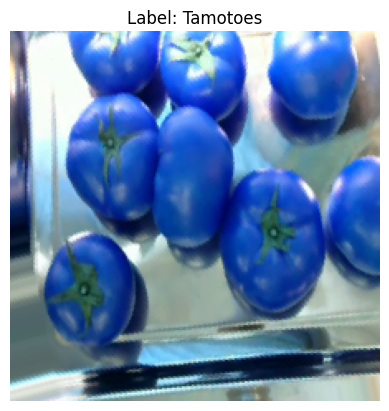

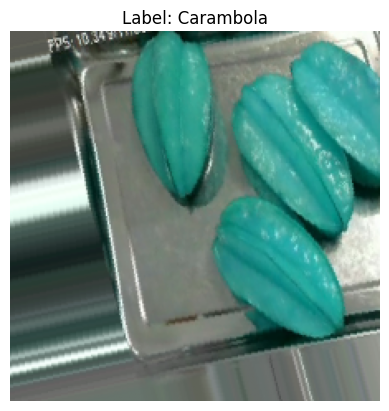

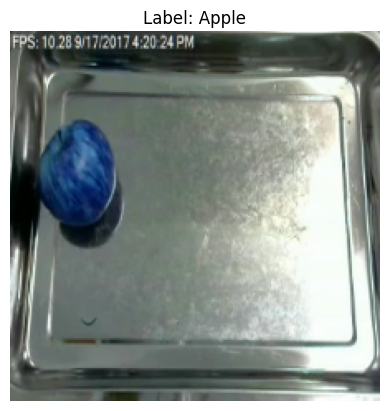

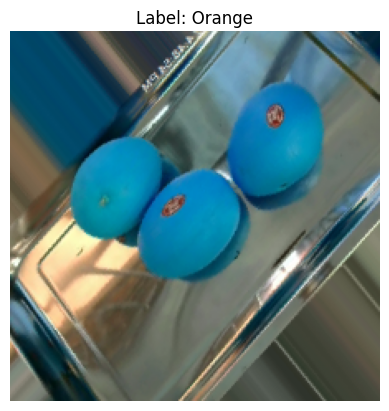

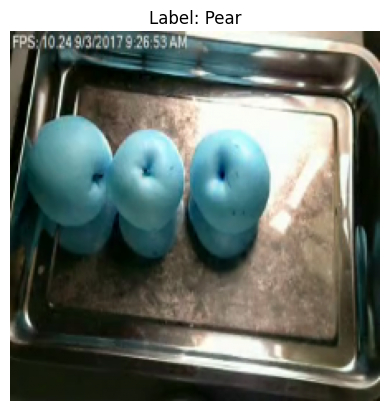

Mostrando apenas as primeiras 5 imagens.


In [ ]:
# Teste para verificar se as imagens estão batendo com os labels
# Rodado 28/11/2024 as 13:39

# Exibe imagens e rótulos de cada conjunto
display_dataset(X_val, y_val, "Validação")

In [ ]:
y_test

array(['Pear', 'Banana', 'Plum', 'Muskmelon', 'Apple', 'Peach', 'Apple',
       'Guava', 'Muskmelon', 'Kiwi', 'Kiwi', 'Pitaya', 'Pear', 'Orange',
       'Guava', 'Kiwi', 'Carambola', 'Persimmon', 'Pear', 'Orange',
       'Apple', 'Apple', 'Pomegranet', 'Pear', 'Apple', 'Mango', 'Mango',
       'Plum', 'Apple', 'Banana', 'Mango', 'Mango', 'Muskmelon', 'Kiwi',
       'Mango', 'Persimmon', 'Plum', 'Plum', 'Guava', 'Banana', 'Apple',
       'Carambola', 'Guava', 'Kiwi', 'Banana', 'Pear', 'Muskmelon',
       'Pear', 'Mango', 'Kiwi', 'Pitaya', 'Mango', 'Pear', 'Pitaya',
       'Kiwi', 'Apple', 'Mango', 'Pomegranet', 'Plum', 'Kiwi',
       'Muskmelon', 'Peach', 'Apple', 'Guava', 'Persimmon', 'Mango',
       'Banana', 'Guava', 'Muskmelon', 'Persimmon', 'Mango', 'Apple',
       'Pomegranet', 'Pomegranet', 'Banana', 'Apple', 'Pear', 'Pear',
       'Guava', 'Orange', 'Apple', 'Plum', 'Guava', 'Pitaya', 'Mango',
       'Guava', 'Pitaya', 'Mango', 'Mango', 'Peach', 'Guava', 'Kiwi',
       'Kiwi', '

Exibindo elementos do conjunto: Teste


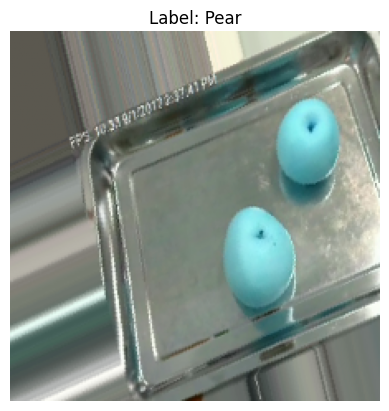

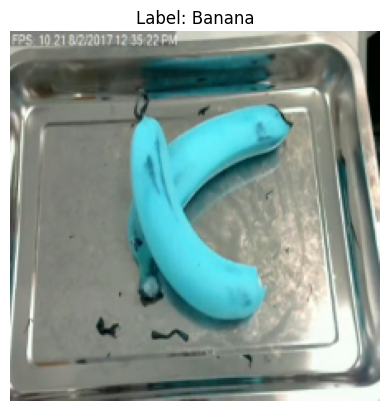

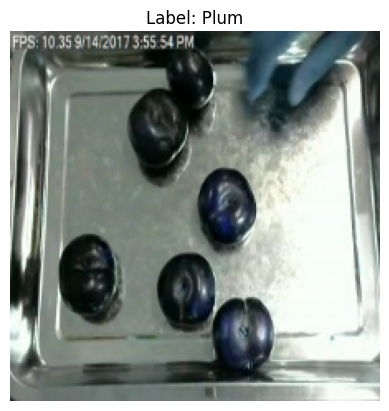

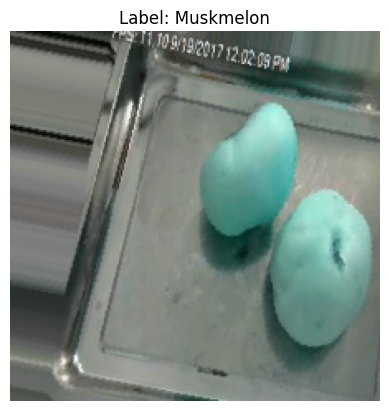

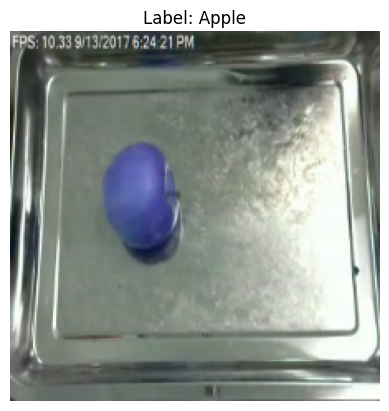

Mostrando apenas as primeiras 5 imagens.


In [ ]:
display_dataset(X_test, y_test, "Teste")

In [ ]:
y_train

array(['Peach', 'Apple', 'Pitaya', 'Kiwi', 'Pear', 'Orange', 'Kiwi',
       'Tamotoes', 'Pear', 'Plum', 'Guava', 'Kiwi', 'Guava', 'Peach',
       'Pitaya', 'Apple', 'Orange', 'Banana', 'Apple', 'Kiwi',
       'Pomegranet', 'Plum', 'Pear', 'Apple', 'Pomegranet', 'Kiwi',
       'Muskmelon', 'Pitaya', 'Persimmon', 'Apple', 'Guava', 'Pear',
       'Mango', 'Apple', 'Pitaya', 'Apple', 'Orange', 'Pitaya', 'Pear',
       'Orange', 'Guava', 'Pitaya', 'Pomegranet', 'Tamotoes', 'Tamotoes',
       'Peach', 'Peach', 'Mango', 'Mango', 'Mango', 'Plum', 'Apple',
       'Pitaya', 'Mango', 'Pear', 'Guava', 'Apple', 'Pitaya', 'Apple',
       'Pomegranet', 'Carambola', 'Carambola', 'Pitaya', 'Apple', 'Mango',
       'Peach', 'Guava', 'Persimmon', 'Muskmelon', 'Kiwi', 'Plum',
       'Orange', 'Banana', 'Carambola', 'Muskmelon', 'Orange', 'Peach',
       'Mango', 'Pear', 'Kiwi', 'Pear', 'Kiwi', 'Apple', 'Banana', 'Kiwi',
       'Carambola', 'Pear', 'Pear', 'Apple', 'Persimmon', 'Peach',
       'Pomegranet'

Exibindo elementos do conjunto: Treino


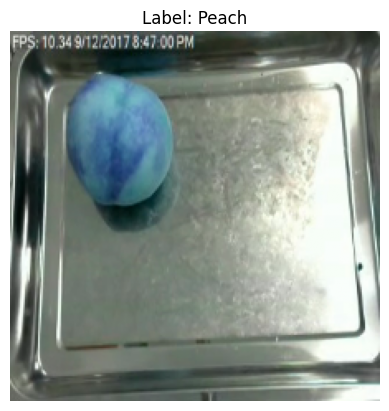

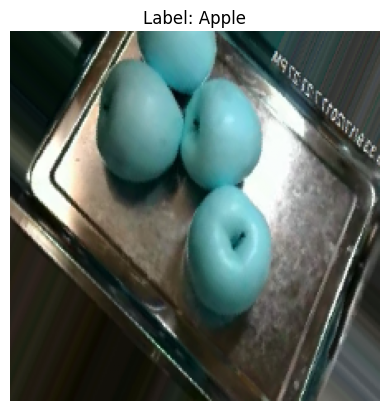

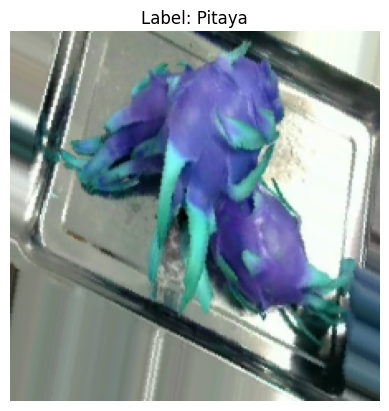

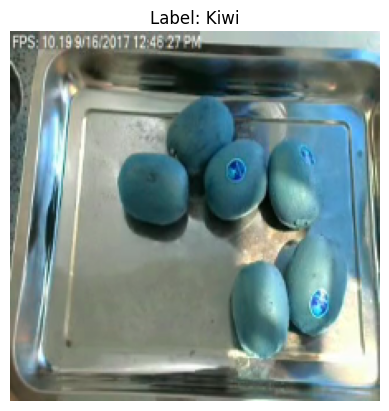

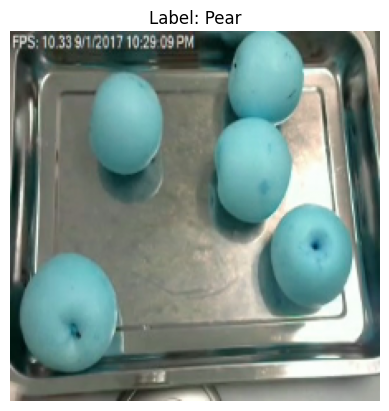

Mostrando apenas as primeiras 5 imagens.


In [ ]:
display_dataset(X_train, y_train, "Treino")

### 3.5.2 - Mexer

In [ ]:
y_val

array(['Tamotoes', 'Carambola', 'Apple', 'Orange', 'Pear', 'Mango',
       'Plum', 'Pomegranet', 'Carambola', 'Mango', 'Mango', 'Peach',
       'Guava', 'Peach', 'Mango', 'Pear', 'Apple', 'Kiwi', 'Pitaya',
       'Pear', 'Apple', 'Mango', 'Pomegranet', 'Muskmelon', 'Kiwi',
       'Pear', 'Kiwi', 'Apple', 'Tamotoes', 'Muskmelon', 'Tamotoes',
       'Persimmon', 'Kiwi', 'Mango', 'Pitaya', 'Peach', 'Pitaya', 'Guava',
       'Orange', 'Pitaya', 'Muskmelon', 'Muskmelon', 'Mango', 'Carambola',
       'Persimmon', 'Apple', 'Tamotoes', 'Apple', 'Apple', 'Apple',
       'Muskmelon', 'Pitaya', 'Apple', 'Banana', 'Guava', 'Guava',
       'Apple', 'Apple', 'Muskmelon', 'Orange', 'Kiwi', 'Pear', 'Banana',
       'Kiwi', 'Guava', 'Guava', 'Pear', 'Guava', 'Apple', 'Orange',
       'Pitaya', 'Apple', 'Plum', 'Mango', 'Banana', 'Kiwi', 'Orange',
       'Peach', 'Peach', 'Orange', 'Kiwi', 'Pitaya', 'Banana', 'Apple',
       'Mango', 'Plum', 'Carambola', 'Orange', 'Mango', 'Kiwi', 'Kiwi',
       'Tamoto

Exibindo elementos do conjunto: Validação


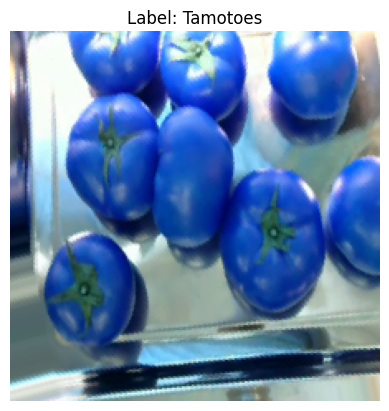

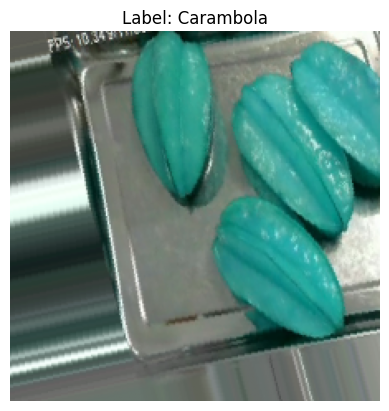

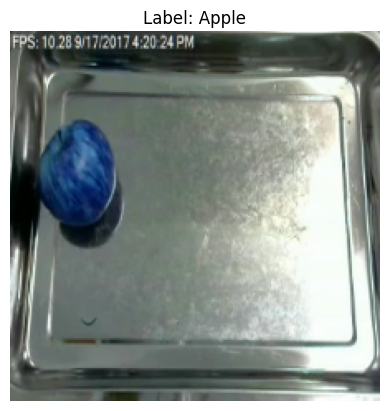

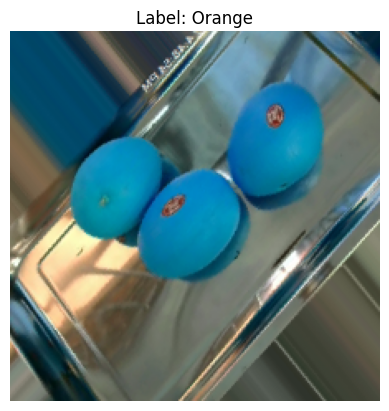

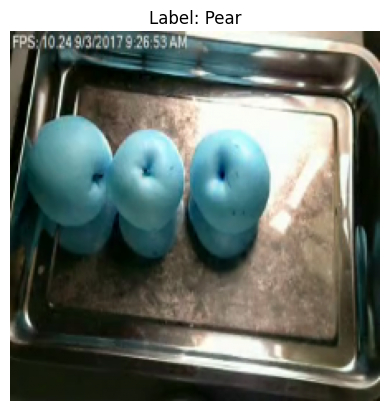

Mostrando apenas as primeiras 5 imagens.


In [ ]:
display_dataset(X_val, y_val, "Validação")

In [ ]:
y_test

array(['Pear', 'Banana', 'Plum', 'Muskmelon', 'Apple', 'Peach', 'Apple',
       'Guava', 'Muskmelon', 'Kiwi', 'Kiwi', 'Pitaya', 'Pear', 'Orange',
       'Guava', 'Kiwi', 'Carambola', 'Persimmon', 'Pear', 'Orange',
       'Apple', 'Apple', 'Pomegranet', 'Pear', 'Apple', 'Mango', 'Mango',
       'Plum', 'Apple', 'Banana', 'Mango', 'Mango', 'Muskmelon', 'Kiwi',
       'Mango', 'Persimmon', 'Plum', 'Plum', 'Guava', 'Banana', 'Apple',
       'Carambola', 'Guava', 'Kiwi', 'Banana', 'Pear', 'Muskmelon',
       'Pear', 'Mango', 'Kiwi', 'Pitaya', 'Mango', 'Pear', 'Pitaya',
       'Kiwi', 'Apple', 'Mango', 'Pomegranet', 'Plum', 'Kiwi',
       'Muskmelon', 'Peach', 'Apple', 'Guava', 'Persimmon', 'Mango',
       'Banana', 'Guava', 'Muskmelon', 'Persimmon', 'Mango', 'Apple',
       'Pomegranet', 'Pomegranet', 'Banana', 'Apple', 'Pear', 'Pear',
       'Guava', 'Orange', 'Apple', 'Plum', 'Guava', 'Pitaya', 'Mango',
       'Guava', 'Pitaya', 'Mango', 'Mango', 'Peach', 'Guava', 'Kiwi',
       'Kiwi', '

Exibindo elementos do conjunto: Teste


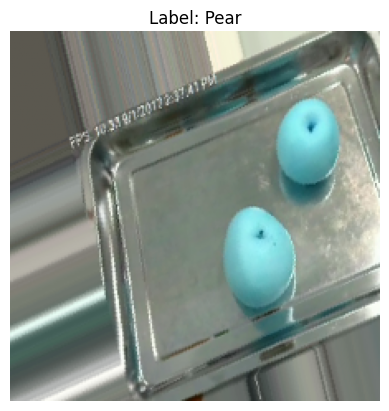

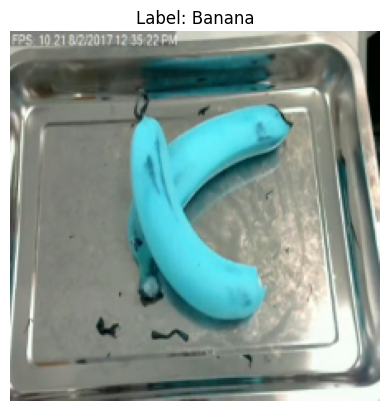

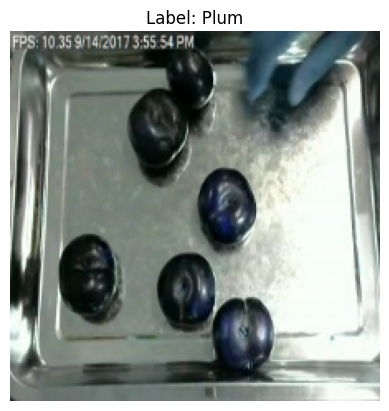

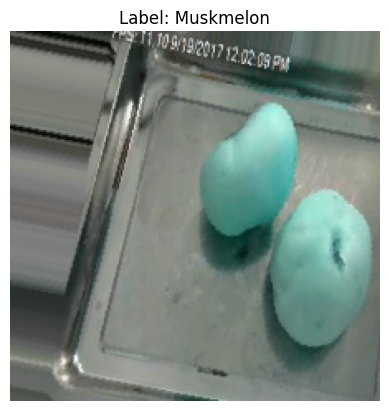

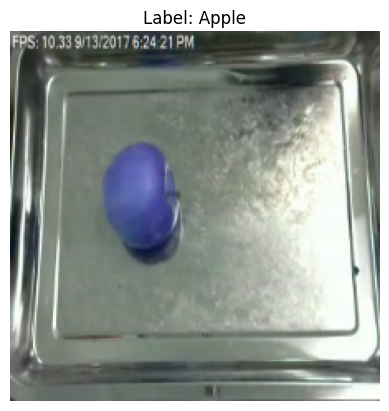

Mostrando apenas as primeiras 5 imagens.


In [ ]:
display_dataset(X_test, y_test, "Teste")

In [ ]:
y_train

array(['Peach', 'Apple', 'Pitaya', 'Kiwi', 'Pear', 'Orange', 'Kiwi',
       'Tamotoes', 'Pear', 'Plum', 'Guava', 'Kiwi', 'Guava', 'Peach',
       'Pitaya', 'Apple', 'Orange', 'Banana', 'Apple', 'Kiwi',
       'Pomegranet', 'Plum', 'Pear', 'Apple', 'Pomegranet', 'Kiwi',
       'Muskmelon', 'Pitaya', 'Persimmon', 'Apple', 'Guava', 'Pear',
       'Mango', 'Apple', 'Pitaya', 'Apple', 'Orange', 'Pitaya', 'Pear',
       'Orange', 'Guava', 'Pitaya', 'Pomegranet', 'Tamotoes', 'Tamotoes',
       'Peach', 'Peach', 'Mango', 'Mango', 'Mango', 'Plum', 'Apple',
       'Pitaya', 'Mango', 'Pear', 'Guava', 'Apple', 'Pitaya', 'Apple',
       'Pomegranet', 'Carambola', 'Carambola', 'Pitaya', 'Apple', 'Mango',
       'Peach', 'Guava', 'Persimmon', 'Muskmelon', 'Kiwi', 'Plum',
       'Orange', 'Banana', 'Carambola', 'Muskmelon', 'Orange', 'Peach',
       'Mango', 'Pear', 'Kiwi', 'Pear', 'Kiwi', 'Apple', 'Banana', 'Kiwi',
       'Carambola', 'Pear', 'Pear', 'Apple', 'Persimmon', 'Peach',
       'Pomegranet'

Exibindo elementos do conjunto: Treino


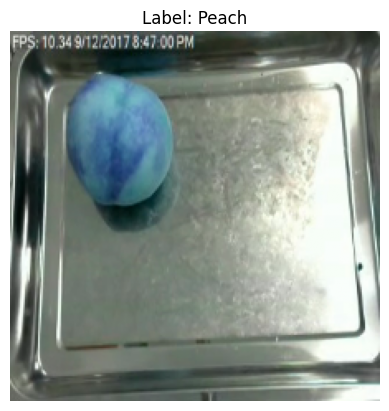

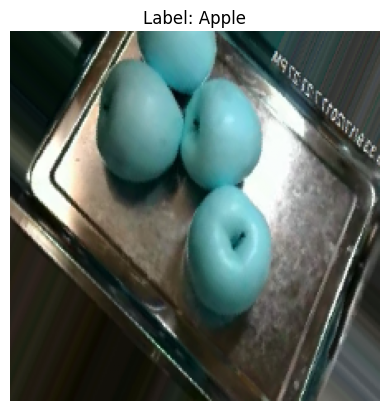

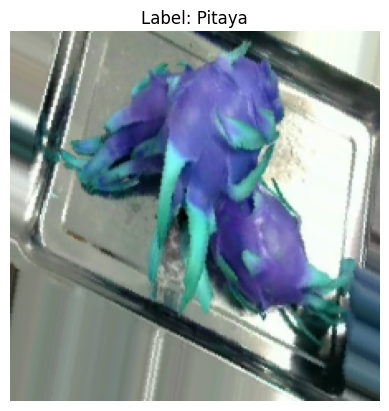

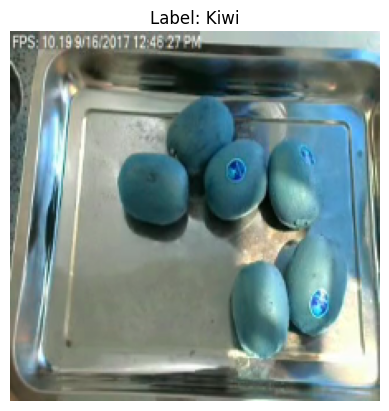

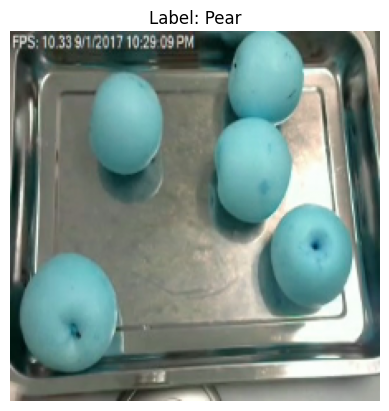

Mostrando apenas as primeiras 5 imagens.


In [ ]:
display_dataset(X_train, y_train, "Treino")

## 3.6 - Faz Sentido Utilizar Validação Cruzada?


Não iremos utilizar validação cruzada devido ao alto custo computacional.
Em vez disso, uma divisão treino/validação/teste é uma prática bem estabelecida para garantir uma boa generalização.

## 3.7 - Seleção de Atributos (Feature Selection)

Para CNNs, a melhor abordagem é garantir que as imagens estejam padronizadas, redimensionadas e bem distribuídas entre as classes.

# 4. Modelagem e Treinamento
---

## 4.1 - Seleção de algoritmos

Usaremos 3 algoritmos para 4 modelos:

1. Modelo Convolutional Neural Network (CNN) (seção 4.3)
2. Modelo Convolutional Neural Network (CNN) com KerasTuner (seção 6.1)
3. Modelo pré-treinado ResNet (seção 6.2)
4. Modelo pré-treinado DenseNet (seção 6.3)

## 4.2 - Ajustes Iniciais de Hiperparâmetros


- Otimizador:

Usaremos o otimizador Adam, que é um dos otimizadores mais populares devido à sua capacidade de ajustar a taxa de aprendizado automaticamente durante o treinamento.

- Learning rate:

Definiremos uma taxa de aprendizado inicial moderada, 0.001, que é o padrão quando passamos o optimizer='adam'

- Batch size:

Usaremos tamanhos de lote igual a 32 para tentar equilibrar entre o uso de memória e o tempo de treinamento.

- Épocas:

O número de épocas será 20 devido ao alto tempo demandado para treinamento.

- Função de Perda:

"categorical_crossentropy" foi escolhida pois é uma função de perda comumente usada para problemas de classificação multi-classes.

## 4.3 - Treinamento do modelo

Inicialmente treinaremos o primeiro modelo de CNN com:
- Imagens de entrada no tamanho 224x224 e 3 canais para RBG;

- 3 camadas convolucionais: a primeira com 32 filtros, a segunda com 64 e a terceira com 128, todas de tamanho 3x3 e função de ativação ReLU;

- Aplicação de Pooling para reduzir a dimensionalidade das imagens e extrair as características das imagens;

- Uma camada Flatten para reduzir a saída da última camada em um vetor unidimensional para passar pela próxima camada densa;

- Uma camada densa totalmente conectada com 128 neurônios;

- Um dropout de 50% para evitar overfitting;

- Uma camada densa final com 15 saídas (uma para cada label) com ativação Softmax para calcular a probabilidade de classificação.

Compilaremos o modelo com otimizador Adam para ajustar os pesos do modelo durante o treinamento, função de perda "categorical_crossentropy" e acurácia como métrica de avaliação.

Imprimiremos na tela o sumário do modelo apenas para conferência.

Por fim, treinaremos o modelo com 20 épocas, usando os dados de treino e validação para posterior análise.

In [ ]:
# Definição do modelo
model_cnn = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')  # 15 classes
])

In [ ]:
# Compilação do modelo
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#imprime o resumo do modelo
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

- Nesse trecho de código iremos realizar o treino do modelo, mas não é necessário rodá-lo novamente pois em seguida ele será salvo, portanto apenas carregue o modelo e seu histórico salvo na seção seguinte.

In [ ]:
# Treinamento
history_cnn = model_cnn.fit(X_train, y_train_encoded,
                    validation_data=(X_val, y_val_encoded),
                    epochs=20,
                    batch_size=32)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.1074 - loss: 2.7859 - val_accuracy: 0.2000 - val_loss: 2.3089
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.2615 - loss: 2.2718 - val_accuracy: 0.5667 - val_loss: 1.6940
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.4953 - loss: 1.6627 - val_accuracy: 0.6200 - val_loss: 1.2459
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.6333 - loss: 1.1307 - val_accuracy: 0.6467 - val_loss: 0.9460
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.7760 - loss: 0.6315 - val_accuracy: 0.6600 - val_loss: 0.9216
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 178s 6s/step - accuracy: 0.8485 - loss: 0.4797 - val_accuracy: 0.6933 - val_loss: 0.9743
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.8848 - loss: 0.4028 - val_accuracy: 0.7200 - val_loss: 0.9269
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.9407 - loss: 0.2397 - val_accuracy: 0.7333 - val_l

## 4.4 - Salvar e carregar modelo e histórico

Vamos salvar e carregar o modelo treinado e seu histórico com essas linhas de código. A partir daqui, as análises serão referenciadas a esses arquivos carregados, para que não seja necessário refazer o treinamento do modelo sempre que precisar reiniciar o ambiente de execução do Google Colab.

- Obs.: Não é necessário rodar o trecho de código de salvar os arquivos, rode apenas o de carregar.

In [ ]:
# Salvar

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho no Google Drive onde o histórico será salvo
history_path = '/content/drive/MyDrive/history_cnn.pkl'

# Salvar o histórico como arquivo pickle
with open(history_path, 'wb') as f:
    pickle.dump(history_cnn.history, f)

# Salva o modelo no Google Drive no formato Keras
model_cnn.save("/content/drive/MyDrive/model_cnn.keras")

Mounted at /content/drive


In [ ]:
# Carregar

# Montar o Google Drive
drive.mount('/content/drive')

# Carregar o histórico do modelo em um link público no Google Drive

file_id = '13dbd9qfMOT8nRWCFvkprZDNvyYM6S8_-'
download_url = f'https://drive.google.com/uc?id={file_id}'

# Definir o caminho onde o arquivo será salvo
output_path = 'history_cnn.pkl'

# Fazer o download do arquivo Pickle
!gdown {download_url} -O {output_path}

# Carregar o histórico do arquivo Pickle
with open(output_path, 'rb') as f:
    history_loaded_cnn = pickle.load(f)

# Carrega o modelo salvo no formato Keras
file_id_model = '1xlw05Ki3aFgPWlD9LHj7MnE5htEoc908'
download_url_model = f'https://drive.google.com/uc?id={file_id_model}'

output_path_model = 'model_cnn.keras'

!gdown {download_url_model} -O {output_path_model}

model_loaded_cnn = load_model('/content/model_cnn.keras')

Mounted at /content/drive
Downloading...
From: https://drive.google.com/uc?id=13dbd9qfMOT8nRWCFvkprZDNvyYM6S8_-
To: /content/history_cnn.pkl
100% 796/796 [00:00<00:00, 2.91MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1xlw05Ki3aFgPWlD9LHj7MnE5htEoc908
From (redirected): https://drive.google.com/uc?id=1xlw05Ki3aFgPWlD9LHj7MnE5htEoc908&confirm=t&uuid=d338bd6e-84e1-4574-8fff-a49a776bcc8f
To: /content/model_cnn.keras
100% 134M/134M [00:01<00:00, 89.1MB/s]


# 5. Avaliação de Resultados
---


## 5.1 - Gráficos de acurária e perda ao longo das épocas

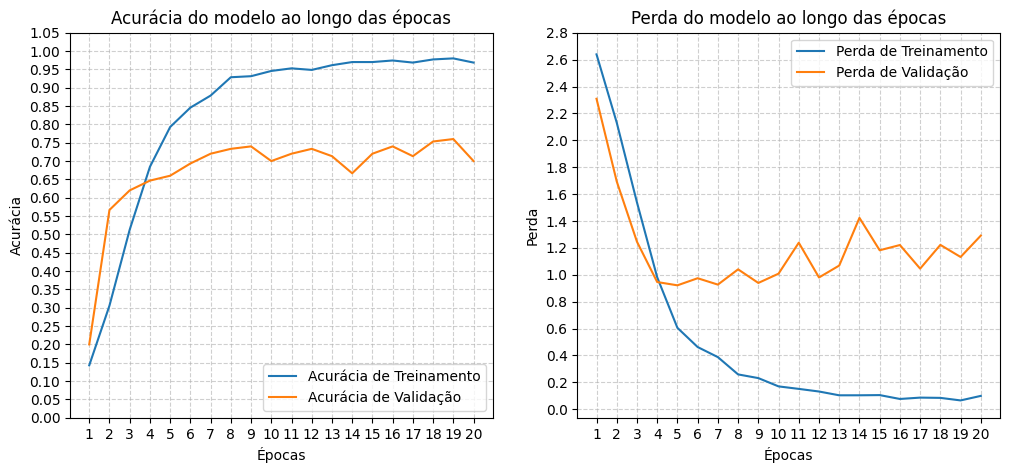

In [ ]:
# Plotando o gráfico
plt.figure(figsize=(12, 5))

# Gráfico de acurácia
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history_loaded_cnn['accuracy']) + 1), history_loaded_cnn['accuracy'], label='Acurácia de Treinamento')
plt.plot(range(1, len(history_loaded_cnn['val_accuracy']) + 1), history_loaded_cnn['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do modelo ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(1, 21))
plt.yticks(ticks=np.arange(0, 1.1, 0.05))
plt.legend(loc='lower right')

# Gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history_loaded_cnn['loss']) + 1), history_loaded_cnn['loss'], label='Perda de Treinamento')
plt.plot(range(1, len(history_loaded_cnn['val_loss']) + 1), history_loaded_cnn['val_loss'], label='Perda de Validação')
plt.title('Perda do modelo ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(1, 21))
plt.yticks(ticks=np.arange(0, 3, 0.2))
plt.legend(loc='upper right')

plt.show()

## 5.2 - Matriz de confusão do modelo

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7218 - loss: 1.5379
Test Accuracy CNN: 72.67%
Test Loss CNN: 154.18%
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


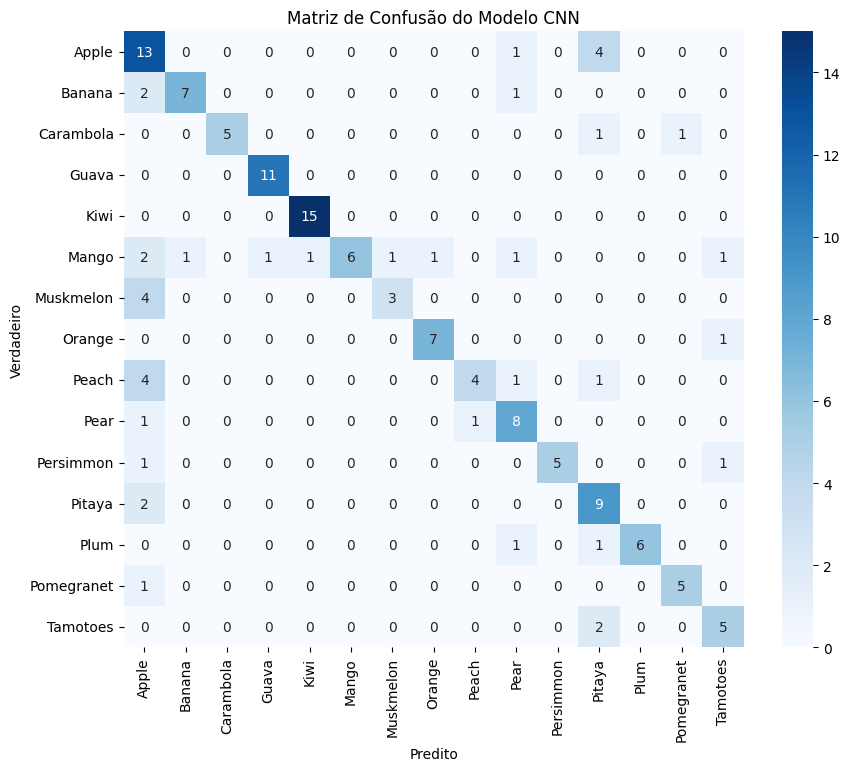

In [ ]:
# Avaliação do modelo
test_loss_cnn, test_accuracy_cnn = model_loaded_cnn.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy CNN: {test_accuracy_cnn*100:.2f}%")
print(f"Test Loss CNN: {test_loss_cnn*100:.2f}%")

# Matriz de confusão
y_pred_cnn = model_loaded_cnn.predict(X_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

y_true_classes_cnn = np.argmax(y_test_encoded, axis=1)
cm_cnn = confusion_matrix(y_true_classes_cnn, y_pred_classes_cnn)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_encoder.categories_[0], yticklabels=one_hot_encoder.categories_[0])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão do Modelo CNN')
plt.show()

## 5.3 - Precision, Recall e F1-Score

In [ ]:
print(classification_report(y_true_classes_cnn, y_pred_classes_cnn, target_names=one_hot_encoder.categories_[0]))

              precision    recall  f1-score   support

       Apple       0.43      0.72      0.54        18
      Banana       0.88      0.70      0.78        10
   Carambola       1.00      0.71      0.83         7
       Guava       0.92      1.00      0.96        11
        Kiwi       0.94      1.00      0.97        15
       Mango       1.00      0.40      0.57        15
   Muskmelon       0.75      0.43      0.55         7
      Orange       0.88      0.88      0.88         8
       Peach       0.80      0.40      0.53        10
        Pear       0.62      0.80      0.70        10
   Persimmon       1.00      0.71      0.83         7
      Pitaya       0.50      0.82      0.62        11
        Plum       1.00      0.75      0.86         8
  Pomegranet       0.83      0.83      0.83         6
    Tamotoes       0.62      0.71      0.67         7

    accuracy                           0.73       150
   macro avg       0.81      0.72      0.74       150
weighted avg       0.79   

In [ ]:
print("\nMatriz de Confusão (CNN):\n")
print(cm_cnn)


Matriz de Confusão (CNN):

[[13  0  0  0  0  0  0  0  0  1  0  4  0  0  0]
 [ 2  7  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  1  0  1  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  0  1  1  6  1  1  0  1  0  0  0  0  1]
 [ 4  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  1]
 [ 4  0  0  0  0  0  0  0  4  1  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  1  8  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  5  0  0  0  1]
 [ 2  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  1  6  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  5]]


## 5.4 - Análises

- Gráficos de acurácia e perda:

* * Treinamento:

O modelo começou com uma acurácia no treino de 10,74% na primeira época e atingiu 97,78% na última. A perda no treinamento reduziu bastante ao longo das épocas, começando em 2,7859 e chegando a 0,0785.

* * Validação:

A acurácia inicial na validação foi de 20% e estabilizou em torno de 70~75% a partir da época 8, com pico em 76%. A perda na validação foi diminuindo até a quarta época, a partir disso os valores começaram a subir ou oscilar.

* * Overfitting:

O modelo demonstra sinais de overfitting após a época 5 aproximadamente. A acurácia no conjunto de treinamento continua aumentando, porém a acurácia da validação não melhora proporcionalmente. Além disso, a perda no treinamento cai bastante até o final, enquanto a perda na validação volta a aumentar ou oscilar. No final temos um modelo com acurácia de de treino muito maior que a acurácia de validação, e perda no treinamento muito menor que na validação, o que indica que o modelo perdeu a capacidade de generalizar e possivelmente está "memorizando" os dados de treinamento.

- Matriz de confusão

Apesar da matriz de confusão mostrar um bom desempenho de forma geral, com a maioria das classes tendo acertos precisos, alguns detalhes precisam ser notados:

Muskmelon, Mango e Peach foram as classes que mais tiveram confusão com outras classes;
Apple foi a classe que mais foi confundida, ou seja, o modelo interpretou que a fruta era Apple para frutas que não eram.

- Métricas de Avaliação

Com a precisão vemos que além de Apple, as frutas Pear e Tamotoes foram bastante confundidas, tendo uma precisão de 62%. Outras classes tiveram um desempenho muito bom, com 100%, como Carambola, Persimmon e Plum.

Analisando o Recall, vemos que as piores classes foram as já mencionadas Mango, Muskmelon e Peach, com 40%, 43% e 40% respectivamente.

Com o F1-Score vemos que as classes com melhor desempenho foram Guava e Kiwi, com valores acima de 95%.

- Conclusão:

Poderiamos aumentar o número de exemplos das classes com maior confusão para tentar melhorar o desempenho delas.

Apesar dos 72,67% de acurácia usando os dados de teste, precisamos reduzir o overfitting, portanto vamos tentar aplicar uma técnica de Data Augmentation seguido de uma otimização dos hiperparâmetros usando o KerasTuner.HyperBand, que será feito na próxima seção.

# 6. Treinando outros modelos para comparação
---

## 6.1 - Mesmo modelo CNN com Data Augmentatation e ajuste de hiperparâmetros

Vamos tentar otimizar o modelo utilizando Data Augmentation e o ajuste de seus hiperparâmetros com o KerasTuner.

### 6.1.1 - Data Augmentation

Aplicaremos rotação, zoom, espelhamento e mudanças de brilho, para tentar melhorar a capacidade do modelo de generalizar e evitar o overfitting do modelo.

In [ ]:
# Configurando Data Augmentation
train_datagen = ImageDataGenerator(  # Cria o gerador de dados
    rotation_range=40,  # Gira a imagem até 40 graus
    width_shift_range=0.2,  # Desloca a imagem horizontalmente
    height_shift_range=0.2,  # Desloca a imagem verticalmente
    shear_range=0.2,  # Aplica um corte na imagem
    zoom_range=0.2,  # Aumenta ou diminui a imagem
    horizontal_flip=True,  # Gira a imagem horizontalmente
    fill_mode='nearest')  # Preenche os pixels resultantes das transformações

val_datagen = ImageDataGenerator()

In [ ]:
# Carregar as imagens com data augmentation
train_generator = train_datagen.flow(X_train, y_train_encoded, batch_size=32, seed=SEED)
val_generator = val_datagen.flow(X_val, y_val_encoded, batch_size=32, seed=SEED)

### 6.1.2 - Ajuste de hiperparâmetros

Para otimizar os hiperparâmetros:

- Iremos variar o número de filtros para cada camada convolucional, porém manteremos a função de ativação ReLU;
- Faremos o mesmo com a camada densa de saída, mantendo a função de ativação SoftMax;
- Vamos variar o dropout entre 0.2 e 0.5;
- Na compilação do modelo manteremos o optimizador Adam, porém vamos variar a taxa de aprendizado entre 0.001 e 0.0001.
- Adicioneremos um EarlyStopping com patience=2 para interromper o treinamento quando o modelo não melhorar após 2 épocas e ter uma maior velocidade com o KerasTuner.
- Número máximo de épocas permitidas (max_epochs) igual a 8 para cada modelo durante a busca pelos melhores hiperparâmetros.
- factor=5 para determinar a redução do número de configurações testadas em cada rodada do Hyperband, ou seja, testará 1/5 das configurações anteriores.
- epochs=3 para especificar o número de épocas para cada modelo durante a execução inicial do tuner.search.

OBS¹.:
- Tentei realizar um tuning com uma amplitude maior de possibilidades, como min_value e max_value maiores e step menor para as camadas de convolução, mais opções de learning_rate e maior número de epochs, porém isso estava deixando custoso demais para rodar (demorando muito tempo), portanto ajustei o tuning com esses valores citados acima.

OBS².:
- Nesse trecho de código iremos realizar o tuning do modelo, mas não é necessário rodá-lo novamente pois em seguida salvaremos o melhor modelo encontrado, portanto apenas carregue o modelo e seu histórico de treino salvo na seção seguinte.

In [ ]:
# Aqui iremos montar o Google Drive apenas para salvar o modelo com ModelCheckpoint
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Função para construir o modelo com Keras Tuner
def build_model(hp):
    model = Sequential()

    # Camada de entrada com Input explícito
    model.add(Input(shape=(224, 224, 3)))

    # Primeira camada de convolução
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=64, step=32),
        kernel_size=(3, 3),
        activation='relu',
    ))
    model.add(MaxPooling2D((2, 2)))

    # Segunda camada de convolução
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=128, step=64),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))

    # Terceira camada de convolução
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=128, max_value=256, step=128),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))

    # Camada Flatten para converter em vetor
    model.add(Flatten())

    # Camada densa com hiperparâmetro para o número de unidades
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=256, step=128),
        activation='relu'
    ))

    # Camada de Dropout com hiperparâmetro para taxa de dropout
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Camada de saída com softmax para classificação em 15 classes
    model.add(Dense(15, activation='softmax'))

    # Compilação do modelo com hiperparâmetro para a taxa de aprendizado
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Parar caso o modelo não melhore
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

# Configuração do KerasTuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=8,
    factor=5,
    directory='tuner_dir',
    project_name='fruit_classification_hyperparameter_tuning'
)

# Realizar a busca pelos melhores hiperparâmetros
tuner.search(train_generator, epochs=3, validation_data=val_generator, callbacks=[early_stopping])

Trial 13 Complete [00h 56m 14s]
val_accuracy: 0.46000000834465027

Best val_accuracy So Far: 0.6066666841506958
Total elapsed time: 04h 39m 01s


#### 6.1.2.1 - Verificar o melhor modelo e seus parâmetros encontrados

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Melhores hiperparâmetros encontrados:")
print(f"Conv1 Filters: {best_hps.get('conv1_filters')}")
print(f"Conv2 Filters: {best_hps.get('conv2_filters')}")
print(f"Conv3 Filters: {best_hps.get('conv3_filters')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Melhores hiperparâmetros encontrados:
Conv1 Filters: 64
Conv2 Filters: 64
Conv3 Filters: 128
Dense Units: 256
Dropout Rate: 0.2
Learning Rate: 0.001


In [ ]:
# Obtém o melhor modelo encontrado pelo tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Resumo do modelo
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,267,855 (84.95 MB)

 Trainable params: 22,267,855 (84.95 MB)

 Non-trainable params: 0 (0.00 B)

### 6.1.3 - Treinamento do melhor modelo encontrado pelo KerasTuner

- Nesse trecho de código iremos realizar o treino do modelo com os melhores hiperparâmetros encontrados, porém não é necessário rodá-lo novamente pois em seguida ele será salvo, portanto apenas carregue o modelo e seu histórico salvo na seção seguinte.

In [ ]:
best_model_cnn_tuned = build_model(best_hps)

# Treinamento do melhor modelo com dados de treino e validação
history_cnn_tuned = best_model_cnn_tuned.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 240s 10s/step - accuracy: 0.0945 - loss: 3.6615 - val_accuracy: 0.1200 - val_loss: 2.6310
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 255s 10s/step - accuracy: 0.1571 - loss: 2.6173 - val_accuracy: 0.1867 - val_loss: 2.3080
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 266s 10s/step - accuracy: 0.1866 - loss: 2.2454 - val_accuracy: 0.2933 - val_loss: 2.0196
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 226s 10s/step - accuracy: 0.2828 - loss: 2.0550 - val_accuracy: 0.4000 - val_loss: 1.7723
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 235s 10s/step - accuracy: 0.3665 - loss: 1.8414 - val_accuracy: 0.4733 - val_loss: 1.6105
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 236s 10s/step - accuracy: 0.4362 - loss: 1.6059 - val_accuracy: 0.5000 - val_loss: 1.3572
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 243s 11s/step - accuracy: 0.4899 - loss: 1.4189 - val_accuracy: 0.5667 - val_loss: 1.2079
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 237s 11s/step - accuracy: 0.5394 - loss: 1.3210 - val_accuracy: 0.

### 6.1.4 - Salvar e carregar o modelo e histórico

Vamos salvar e carregar o modelo treinado e seu histórico com essas linhas de código. A partir daqui, as análises serão referenciadas a esses arquivos carregados, para que não seja necessário refazer o treinamento do modelo sempre que precisar reiniciar o ambiente de execução do Google Colab.

- Obs.: Não é necessário rodar o trecho de código de salvar os arquivos, rode apenas o de carregar.

In [ ]:
# Salvar

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho no Google Drive onde o histórico será salvo
history_path = '/content/drive/MyDrive/history_cnn_tuned.pkl'

# Salvar o histórico como arquivo pickle
with open(history_path, 'wb') as f:
    pickle.dump(history_cnn_tuned.history, f)

# Salva o modelo no Google Drive no formato Keras
best_model_cnn_tuned.save("/content/drive/MyDrive/best_model_cnn_tuned.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carregar

# Montar o Google Drive
drive.mount('/content/drive')

# Carregar o histórico do modelo em um link público no Google Drive

file_id = '1xAACkOacYw9EFbt8cjhsQJD-WV8r2SXl'
download_url = f'https://drive.google.com/uc?id={file_id}'

# Definir o caminho onde o arquivo será salvo
output_path = 'history_cnn_tuned.pkl'

# Fazer o download do arquivo Pickle
!gdown {download_url} -O {output_path}

# Carregar o histórico do arquivo Pickle
with open(output_path, 'rb') as f:
    history_loaded_cnn_tuned = pickle.load(f)

# Carrega o modelo salvo no formato Keras
file_id_model = '1-0gFSOw0NgDMVN9MIZJu1JziRd576DQB'
download_url_model = f'https://drive.google.com/uc?id={file_id_model}'

output_path_model = 'best_model_cnn_tuned.keras'

!gdown {download_url_model} -O {output_path_model}

model_loaded_cnn_tuned = load_model('/content/best_model_cnn_tuned.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloading...
From: https://drive.google.com/uc?id=1xAACkOacYw9EFbt8cjhsQJD-WV8r2SXl
To: /content/history_cnn_tuned.pkl
100% 796/796 [00:00<00:00, 3.58MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-0gFSOw0NgDMVN9MIZJu1JziRd576DQB
From (redirected): https://drive.google.com/uc?id=1-0gFSOw0NgDMVN9MIZJu1JziRd576DQB&confirm=t&uuid=2475c5a8-b280-455a-ac5c-854e06a390fc
To: /content/best_model_cnn_tuned.keras
100% 267M/267M [00:02<00:00, 126MB/s]


### 6.1.5 - Avaliação de resultados

#### 6.1.5.1 - Gráficos de acurária e perda ao longo das épocas

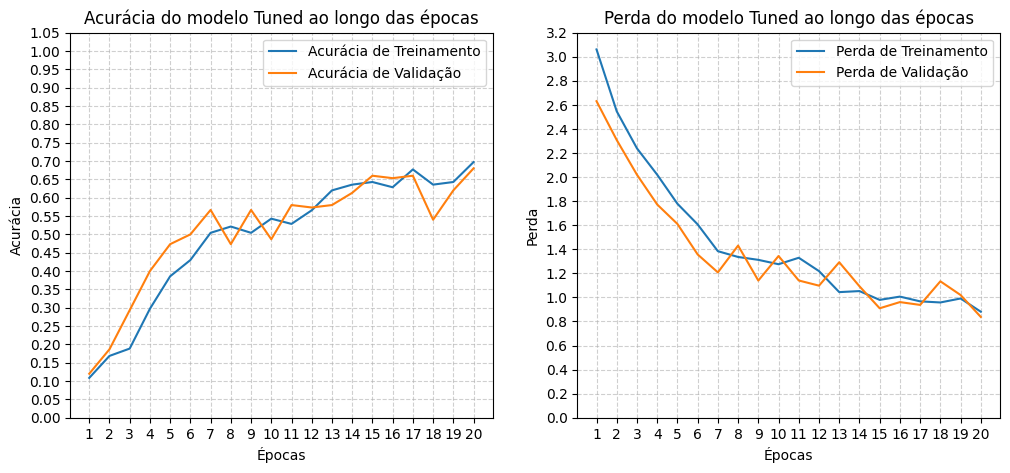

In [ ]:
# Plotando o gráfico
plt.figure(figsize=(12, 5))

# Gráfico de acurácia
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history_loaded_cnn_tuned['accuracy']) + 1), history_loaded_cnn_tuned['accuracy'], label='Acurácia de Treinamento')
plt.plot(range(1, len(history_loaded_cnn_tuned['val_accuracy']) + 1), history_loaded_cnn_tuned['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do modelo Tuned ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(1, 21))
plt.yticks(ticks=np.arange(0, 1.1, 0.05))
plt.legend()

# Gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history_loaded_cnn_tuned['loss']) + 1), history_loaded_cnn_tuned['loss'], label='Perda de Treinamento')
plt.plot(range(1, len(history_loaded_cnn_tuned['val_loss']) + 1), history_loaded_cnn_tuned['val_loss'], label='Perda de Validação')
plt.title('Perda do modelo Tuned ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(1, 21))
plt.yticks(ticks=np.arange(0, 3.4, 0.2))
plt.legend()

plt.show()

#### 6.1.5.2 - Matriz de confusão do modelo

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7385 - loss: 0.8888
Test Accuracy CNN Tuned: 74.67%
Test Loss CNN Tuned: 85.73%
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


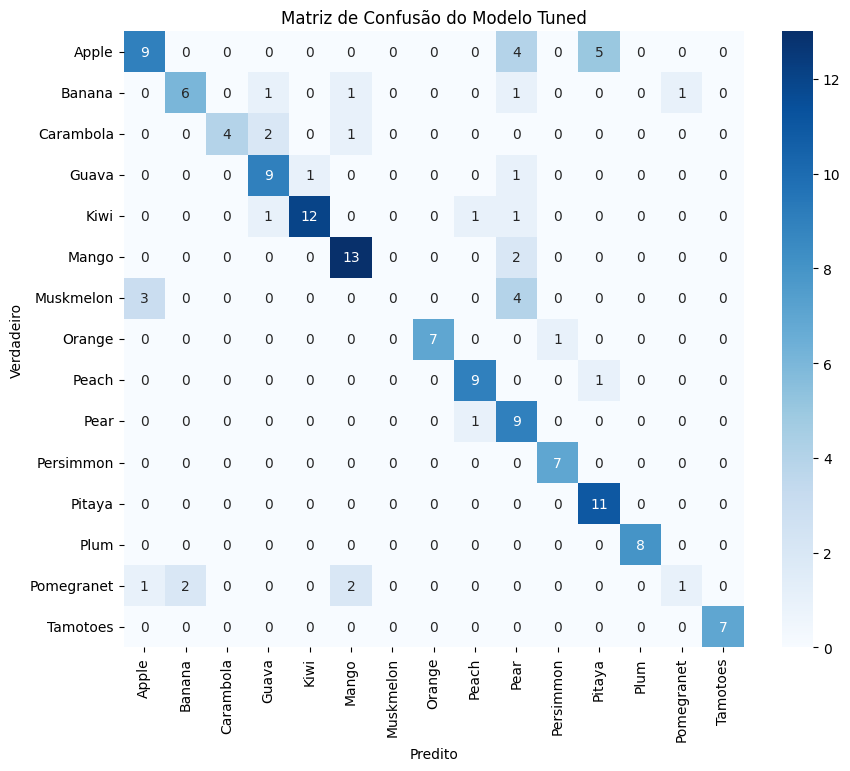

In [ ]:
test_loss_cnn_tuned, test_accuracy_cnn_tuned = model_loaded_cnn_tuned.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy CNN Tuned: {test_accuracy_cnn_tuned*100:.2f}%")
print(f"Test Loss CNN Tuned: {test_loss_cnn_tuned*100:.2f}%")

# 1. Obter as previsões para o conjunto de teste
y_pred_encoded_cnn_tuned = model_loaded_cnn_tuned.predict(X_test)
y_pred_cnn_tuned = np.argmax(y_pred_encoded_cnn_tuned, axis=1)  # Obter o índice com a maior probabilidade

# 2. Decodificar as previsões e os rótulos verdadeiros
y_test_decoded_cnn_tuned = np.argmax(y_test_encoded, axis=1)

# 3. Criar a matriz de confusão
conf_matrix_cnn_tuned = confusion_matrix(y_test_decoded_cnn_tuned, y_pred_cnn_tuned)

# 4. Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_encoder.categories_[0], yticklabels=one_hot_encoder.categories_[0])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão do Modelo Tuned')
plt.show()

#### 6.1.5.3 - Métricas Precison, Recall e F1-Score

In [ ]:
print(classification_report(y_test_decoded_cnn_tuned, y_pred_cnn_tuned, target_names=one_hot_encoder.categories_[0]))

              precision    recall  f1-score   support

       Apple       0.69      0.50      0.58        18
      Banana       0.75      0.60      0.67        10
   Carambola       1.00      0.57      0.73         7
       Guava       0.69      0.82      0.75        11
        Kiwi       0.92      0.80      0.86        15
       Mango       0.76      0.87      0.81        15
   Muskmelon       0.00      0.00      0.00         7
      Orange       1.00      0.88      0.93         8
       Peach       0.82      0.90      0.86        10
        Pear       0.41      0.90      0.56        10
   Persimmon       0.88      1.00      0.93         7
      Pitaya       0.65      1.00      0.79        11
        Plum       1.00      1.00      1.00         8
  Pomegranet       0.50      0.17      0.25         6
    Tamotoes       1.00      1.00      1.00         7

    accuracy                           0.75       150
   macro avg       0.74      0.73      0.71       150
weighted avg       0.74   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\nMatriz de Confusão (CNN Tuned):\n")
print(conf_matrix_cnn_tuned)


Matriz de Confusão (CNN Tuned):

[[ 9  0  0  0  0  0  0  0  0  4  0  5  0  0  0]
 [ 0  6  0  1  0  1  0  0  0  1  0  0  0  1  0]
 [ 0  0  4  2  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  1  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1 12  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  2  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  8  0  0]
 [ 1  2  0  0  0  2  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  7]]


#### 6.1.5.4 - Análises

- Gráficos de acurácia e perda:

* * Treinamento:

O modelo começou com uma acurácia de treino de 9,45% na primeira época e atingiu 68% na última, enquanto a perda no treinamento reduziu continuamente até 0,9214.

* * Validação:

A acurácia inicial na validação foi de 12% e finalizou com 68% na última, porém houve momentos de oscilação bem maiores do que comparado ao treino. A perda na validação foi diminuindo até 0.6869 na última época, também com momentos de oscilação.

* * Overfitting:

Esse modelo aprensentou menores diferenças entre os valores de treino e validação, o que indica uma melhora na generalização e menor overfitting comparado ao primeiro modelo, apesar da acurária ligeiramente menor na validação.

- Matriz de Confusão

Aqui vemos que o modelo teve uma taxa de erros semelhante ao primeiro modelo, porém tendo dificuldades em outras classes, como Muskmelon com nenhum acerto e Pomegranet acertando apenas uma vez.
Apple reduziu sua taxa de acertos.

Apesar disso, outras classes tiveram um bom desempenho, como Plum, que foi a melhor classe, tendo 100% de acertos. Persimmon e Pitaya também foram muito bem, não sendo confudidas por outras frutas.

- Métricas de Avaliação

Aqui vemos a confirmação do que analisamos na matriz de confusão, com Muskmelon e Pomegranet tendo Recall e F1-Score bem ruins, ou seja, o modelo não aprendeu a identificar essas frutas ainda. Apple e Carambola também tiveram um recall relativamente baixo, mostrando que o modelo também teve dificuldades em aprendê-las.

Plum foi a melhor classe, tendo F1-Score de 100%, ou seja, o modelo acertou essa classe em todas as vezes, além de não ter "chutado" Plum para outras  classes que não eram. Persimmon, Orange, Kiwi e Peach também monstraram um excelente aprendizado.

- Conclusão:

Comparado ao primeiro modelo, esse apresentou um overfitting menor, ou seja, está "decorando" menos os dados do conjunto de treino, porém está com dificuldades de aprender certas características que diferenciam as classes Muskmelon e Pomegranet.
Além disso, a acurácia de teste saiu ligeiramente superior ao primeiro modelo, com 2% a mais (75% contra 73%).

Vamos tentar usar alguns modelos pré-treinados para ver se conseguimos um resultado melhor do que esses modelos apresentados. Vamos escolher o ResNet e DenseNet para isso.

## 6.2 - Modelo Pré-treinado ResNet50

Agora vamos usar um modelo pré-treinado ResNet para verificar se ele traz melhorias no desempenho.

Este modelo é carregado com pesos pré-treinados no ImageNet (banco de dados de imagens disponível gratuitamente para pesquisadores para uso não comercial), e suas camadas superiores serão ajustadas para o problema de classificação.

Escolhemos o ResNet50 porque é uma arquitetura muito usada para problemas de classificação de imagens e o uso de pesos pré-treinados no ImageNet diminui a necessidade de treinar o modelo do zero, economizando tempo de treinamento.

### 6.2.1 - Treinamento do modelo

Carregaremos o modelo ResNet50 com os pesos pré-treinados do dataset do ImageNet (weights='imagenet') e removeremos a última camada (include_top=False), que são camadas densas específicas do ImageNet, para que possamos adicionar novas camadas personalizadas.

Congelaremos as camadas da base ResNet para impedir que os pesos sejam atualizados, pois essa base já foi treinada pelo ImageNet e queremos aproveitar esse treino.
Adicionaremos camadas finais com:
- GlobalAveragePooling2D para transformar em vetor a entrada da camada personalidade que virá;
- Uma camada densa de 256 unidades totalmente conectada e função de ativação ReLU;
- Um dropout de 50% para reduzir o overfitting;
- Uma camada densa final com 15 saídas (uma para cada label) com ativação SoftMax para calcular a probabilidade de classificação.

Para a compilação do modelo usaremos:

- Otimizador Adam com taxa de aprendizado de 0.0001;
- categorical_crossentropy como função de perda pois os rótulos foram codificados para vetores binários;
- Acurácia como métrica de avaliação.

Por fim, treinaremos o modelo por 20 épocas.

Obs.:
- Nesse trecho de código iremos realizar o treino do modelo, mas não é necessário rodá-lo novamente pois em seguida ele será salvo, portanto apenas carregue o modelo e seu histórico salvo na seção seguinte.

In [ ]:
# Carrega o modelo pré-treinado com pesos do ImageNet, removendo a camada final (top=False)
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela as camadas do modelo base para não serem treinadas
for layer in base_model_resnet.layers:
    layer.trainable = False

# Adiciona novas camadas para personalizar a saída de acordo com o número de classes do dataset
model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')  # Número de classes
])

# Compila o modelo
model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Treina o modelo
history_resnet = model_resnet.fit(train_generator,
                                  epochs=20,
                                  validation_data=val_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 308s 14s/step - accuracy: 0.0745 - loss: 3.2133 - val_accuracy: 0.1200 - val_loss: 2.6893
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 317s 13s/step - accuracy: 0.0846 - loss: 2.9056 - val_accuracy: 0.1133 - val_loss: 2.6513
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 293s 12s/step - accuracy: 0.1112 - loss: 2.8335 - val_accuracy: 0.1200 - val_loss: 2.6479
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 297s 13s/step - accuracy: 0.0872 - loss: 2.7718 - val_accuracy: 0.1200 - val_loss: 2.6458
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 293s 13s/step - accuracy: 0.0813 - loss: 2.7736 - val_accuracy: 0.1200 - val_loss: 2.6425
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 280s 11s/step - accuracy: 0.1135 - loss: 2.6797 - val_accuracy: 0.1200 - val_loss: 2.6393
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 205s 9s/step - accuracy: 0.1093 - loss: 2.7037 - val_accuracy: 0.1200 - val_loss: 2.6372
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 276s 13s/step - accuracy: 0.1100 - loss: 2.6808 - val_accuracy: 0.1200 - val_l

### 6.2.2 - Salvar e carregar o modelo e histórico

Vamos salvar e carregar o modelo treinado e seu histórico com essas linhas de código. A partir daqui, as análises serão referenciadas a esses arquivos carregados, para que não seja necessário refazer o treinamento do modelo sempre que precisar reiniciar o ambiente de execução do Google Colab.

- Obs.: Não é necessário rodar o trecho de código de salvar os arquivos, rode apenas o de carregar.

In [ ]:
# Salvar

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho no Google Drive onde o histórico será salvo
history_path = '/content/drive/MyDrive/history_resnet.pkl'

# Salvar o histórico como arquivo pickle
with open(history_path, 'wb') as f:
    pickle.dump(history_resnet.history, f)

# Salva o modelo no Google Drive no formato Keras
model_resnet.save("/content/drive/MyDrive/model_resnet.keras")

Mounted at /content/drive


In [ ]:
# Carregar

# Montar o Google Drive
drive.mount('/content/drive')

# Carregar o histórico do modelo em um link público no Google Drive

file_id = '1-YubOc5EhsecHvDPc1RPWrYDq2GuHi06'
download_url = f'https://drive.google.com/uc?id={file_id}'

# Definir o caminho onde o arquivo será salvo
output_path = 'history_resnet.pkl'

# Fazer o download do arquivo Pickle
!gdown {download_url} -O {output_path}

# Carregar o histórico do arquivo Pickle
with open(output_path, 'rb') as f:
    history_loaded_resnet = pickle.load(f)

# Carrega o modelo salvo no formato Keras
file_id_model = '1e38lSynGKvhWlnPV2WhRbyUksJ-Xac_a'
download_url_model = f'https://drive.google.com/uc?id={file_id_model}'

output_path_model = 'model_resnet.keras'

!gdown {download_url_model} -O {output_path_model}

model_loaded_resnet = load_model('/content/model_resnet.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloading...
From: https://drive.google.com/uc?id=1-YubOc5EhsecHvDPc1RPWrYDq2GuHi06
To: /content/history_resnet.pkl
100% 796/796 [00:00<00:00, 2.70MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1e38lSynGKvhWlnPV2WhRbyUksJ-Xac_a
From (redirected): https://drive.google.com/uc?id=1e38lSynGKvhWlnPV2WhRbyUksJ-Xac_a&confirm=t&uuid=13a9cab8-ad4e-4899-be40-1b07303745e1
To: /content/model_resnet.keras
100% 101M/101M [00:01<00:00, 79.0MB/s] 


### 6.2.3 - Avaliação de resultado

#### 6.2.3.1 - Gráficos de acurária e perda ao longo das épocas

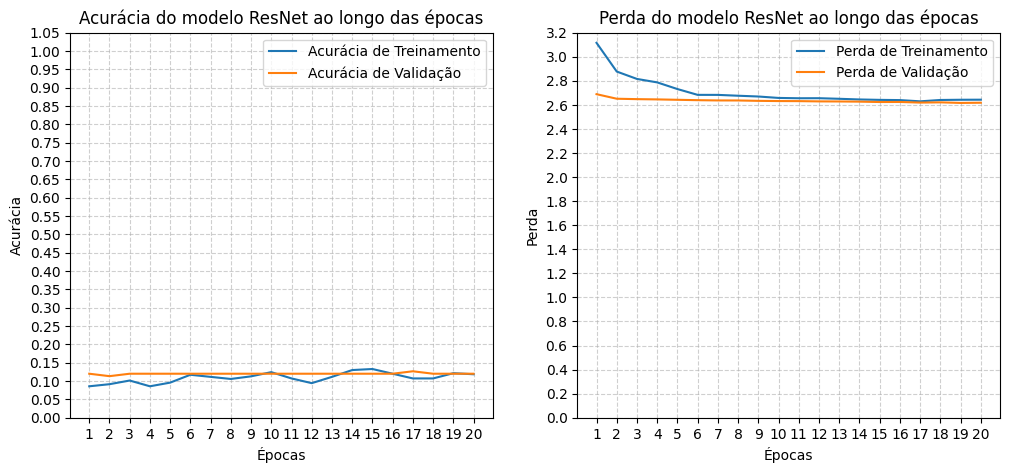

In [ ]:
# Plotando o gráfico
plt.figure(figsize=(12, 5))

# Gráfico de acurácia
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history_loaded_resnet['accuracy']) + 1), history_loaded_resnet['accuracy'], label='Acurácia de Treinamento')
plt.plot(range(1, len(history_loaded_resnet['val_accuracy']) + 1), history_loaded_resnet['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do modelo ResNet ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(1, 21))
plt.yticks(ticks=np.arange(0, 1.1, 0.05))
plt.legend()

# Gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history_loaded_resnet['loss']) + 1), history_loaded_resnet['loss'], label='Perda de Treinamento')
plt.plot(range(1, len(history_loaded_resnet['val_loss']) + 1), history_loaded_resnet['val_loss'], label='Perda de Validação')
plt.title('Perda do modelo ResNet ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(1, 21))
plt.yticks(ticks=np.arange(0, 3.4, 0.2))
plt.legend()

plt.show()

#### 6.2.3.2 - Matriz de confusão do modelo

5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.1364 - loss: 2.5893
Test Accuracy ResNet: 12.00%
Test Loss ResNet: 260.84%
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step


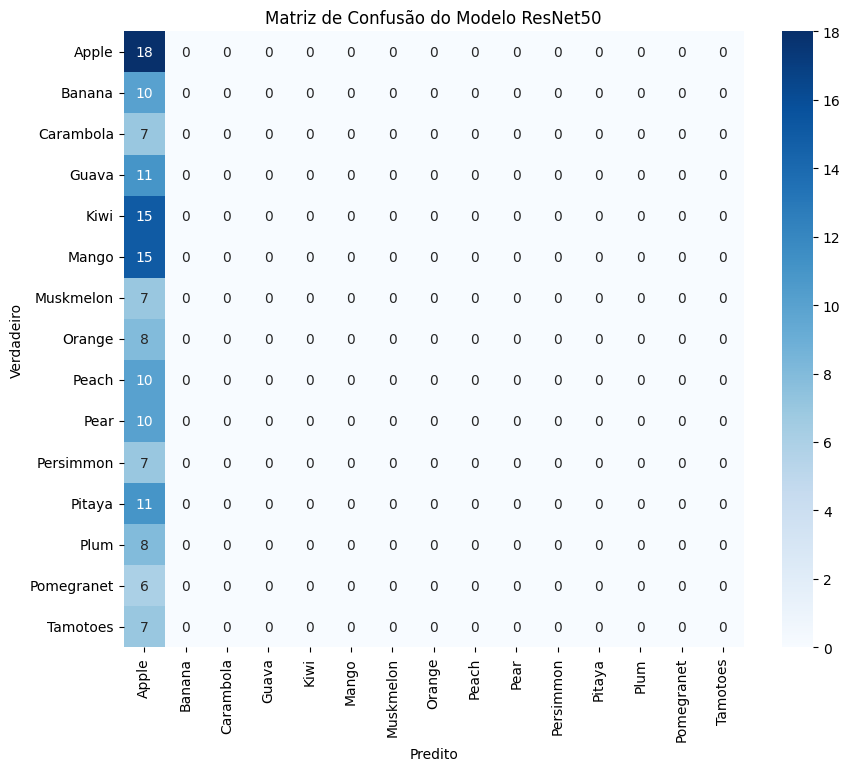

In [ ]:
test_loss_resnet, test_accuracy_resnet = model_loaded_resnet.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy ResNet: {test_accuracy_resnet*100:.2f}%")
print(f"Test Loss ResNet: {test_loss_resnet*100:.2f}%")

# 1. Obter as previsões para o conjunto de teste
y_pred_encoded_resnet = model_loaded_resnet.predict(X_test)
y_pred_resnet = np.argmax(y_pred_encoded_resnet, axis=1)  # Obter o índice com a maior probabilidade

# 2. Decodificar as previsões e os rótulos verdadeiros
y_test_decoded_resnet = np.argmax(y_test_encoded, axis=1)

# 3. Criar a matriz de confusão
conf_matrix_resnet = confusion_matrix(y_test_decoded_resnet, y_pred_resnet)

# 4. Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_encoder.categories_[0], yticklabels=one_hot_encoder.categories_[0])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão do Modelo ResNet50')
plt.show()

#### 6.2.3.3 - Métricas Precision, Recall e F1-Score

In [ ]:
print(classification_report(y_test_decoded_resnet, y_pred_resnet, target_names=one_hot_encoder.categories_[0]))

              precision    recall  f1-score   support

       Apple       0.12      1.00      0.21        18
      Banana       0.00      0.00      0.00        10
   Carambola       0.00      0.00      0.00         7
       Guava       0.00      0.00      0.00        11
        Kiwi       0.00      0.00      0.00        15
       Mango       0.00      0.00      0.00        15
   Muskmelon       0.00      0.00      0.00         7
      Orange       0.00      0.00      0.00         8
       Peach       0.00      0.00      0.00        10
        Pear       0.00      0.00      0.00        10
   Persimmon       0.00      0.00      0.00         7
      Pitaya       0.00      0.00      0.00        11
        Plum       0.00      0.00      0.00         8
  Pomegranet       0.00      0.00      0.00         6
    Tamotoes       0.00      0.00      0.00         7

    accuracy                           0.12       150
   macro avg       0.01      0.07      0.01       150
weighted avg       0.01   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(conf_matrix_resnet)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


#### 6.2.3.4 - Análises

- Gráficos de perda e acurácia:

Através dos gráficos vemos que o modelo não teve evolução nenhuma na acurácia, tanto para o conjunto de treino, quanto para validação, obtendo um valor na última época de apenas 12%. A perda também praticamente não se alterou, principalmente nos dados de validação.

Esses dois fatores indicam que o modelo está sofrendo com bastante underfitting, ou seja, não está aprendendo nada.

- Matriz de confusão:

Pela matriz de confusão podemos ver que o modelo simplesmente "chuta" todas as classes como Apple. Ou seja, o modelo tem um poder de previsão igual zero.

- Métricas de Avaliação:

Novamente confirmamos que todas as classes tem precisão e recall zero, ou seja, o modelo não aprendeu nada.

- Conclusão:

Como o modelo não aprendeu nada, já podemos concluir que não é uma boa escolha seguir com ele, portanto iremos testar mais um modelo pré-treinado com o mesmo princípio nas configurações para ver se o mesmo problema se repete.

## 6.3 - Modelo Pré-treinado DenseNet121

Agora usaremos outro modelo pré-treinado, o DenseNet, para verificar se ele traz melhorias no desempenho.

Assim como o ResNet, carregaremos esse modelo com pesos pré-treinados do ImageNet e ajustaremos suas camadas superiores para o problema de classificação.

### 6.3.1 - Treinamento do modelo

Usaremos as mesmas configurações usadas no modelo anterior:
- Carregar o modelo com os pesos pré-treinados do ImageNet;
- Remover a última camada e adicionar camadas personalizadas;
- Congelar as camadas do modelo pré-treinado para impedir que os pesos sejam atualizados;
- Otimizador Adam com taxa de aprendizado de 0.0001;
- Função de perda "categorical_crossentropy";
- Métrica de avaliação acurácia;
- Treinar o modelo por 20 épocas.

Obs.:
- Nesse trecho de código iremos realizar o treino do modelo, mas não é necessário rodá-lo novamente pois em seguida ele será salvo, portanto apenas carregue o modelo e seu histórico salvo na seção seguinte.

In [ ]:
# Carregar o modelo pré-treinado com pesos do ImageNet, removendo a camada final (top=False)
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela as camadas do modelo base para não serem treinadas
for layer in base_model_densenet.layers:
    layer.trainable = False

# Adicionar novas camadas para personalizar a saída de acordo com o número de classes do dataset
model_densenet = Sequential([
    base_model_densenet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')  # Número de classes
])

# Compilar o modelo
model_densenet.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Treinar o modelo
history_densenet = model_densenet.fit(train_generator,
                                      epochs=20,
                                      validation_data=val_generator)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 237s 10s/step - accuracy: 0.0848 - loss: 3.1694 - val_accuracy: 0.2200 - val_loss: 2.4548
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 284s 11s/step - accuracy: 0.1357 - loss: 2.7195 - val_accuracy: 0.2800 - val_loss: 2.2505
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 236s 11s/step - accuracy: 0.1964 - loss: 2.4735 - val_accuracy: 0.3133 - val_loss: 2.0810
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.3057 - loss: 2.2716 - val_accuracy: 0.4000 - val_loss: 1.9517
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 236s 11s/step - accuracy: 0.3311 - loss: 2.1070 - val_accuracy: 0.4667 - val_loss: 1.8264
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 247s 11s/step - accuracy: 0.3272 - loss: 2.0490 - val_accuracy: 0.5333 - val_loss: 1.7152
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 235s 11s/step - accuracy: 0.4627 - loss: 1.8785 - val_accuracy: 0.5267 - val_loss: 1.6194
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 241s 11s/step - accuracy: 0.4347 - loss: 1.8392 - val_accuracy: 0.5800 - val_

### 6.3.2 - Salvar e carregar o modelo e histórico

Vamos salvar e carregar o modelo treinado e seu histórico com essas linhas de código. A partir daqui, as análises serão referenciadas a esses arquivos carregados, para que não seja necessário refazer o treinamento do modelo sempre que precisar reiniciar o ambiente de execução do Google Colab.

- Obs.: Não é necessário rodar o trecho de código de salvar os arquivos, rode apenas o de carregar.

In [ ]:
# Salvar

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho no Google Drive onde o histórico será salvo
history_path = '/content/drive/MyDrive/history_densenet.pkl'

# Salvar o histórico como arquivo pickle
with open(history_path, 'wb') as f:
    pickle.dump(history_densenet.history, f)

# Salva o modelo no Google Drive no formato Keras
model_densenet.save("/content/drive/MyDrive/model_densenet.keras")

Mounted at /content/drive


In [ ]:
# Carregar

# Montar o Google Drive
drive.mount('/content/drive')

# Carregar o histórico do modelo em um link público no Google Drive

file_id = '1hOmUAjnU6mbnRLM7qxg4iXo5O2eIzozE'
download_url = f'https://drive.google.com/uc?id={file_id}'

# Definir o caminho onde o arquivo será salvo
output_path = 'history_densenet.pkl'

# Fazer o download do arquivo Pickle
!gdown {download_url} -O {output_path}

# Carregar o histórico do arquivo Pickle
with open(output_path, 'rb') as f:
    history_loaded_densenet = pickle.load(f)

# Carrega o modelo salvo no formato Keras
file_id_model = '1OLr0ZMJQQ6d19mzNzLAi25P8zq3MIlUk'
download_url_model = f'https://drive.google.com/uc?id={file_id_model}'

output_path_model = 'model_densenet.keras'

!gdown {download_url_model} -O {output_path_model}

model_loaded_densenet = load_model('/content/model_densenet.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloading...
From: https://drive.google.com/uc?id=1hOmUAjnU6mbnRLM7qxg4iXo5O2eIzozE
To: /content/history_densenet.pkl
100% 796/796 [00:00<00:00, 3.69MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1OLr0ZMJQQ6d19mzNzLAi25P8zq3MIlUk
From (redirected): https://drive.google.com/uc?id=1OLr0ZMJQQ6d19mzNzLAi25P8zq3MIlUk&confirm=t&uuid=d96de2ff-7982-4450-8aa2-bc1b378c8f52
To: /content/model_densenet.keras
100% 32.8M/32.8M [00:00<00:00, 46.6MB/s]


### 6.3.3 - Avaliação de resultados

#### 6.3.3.1 - Gráficos de acurária de perda ao longo das épocas

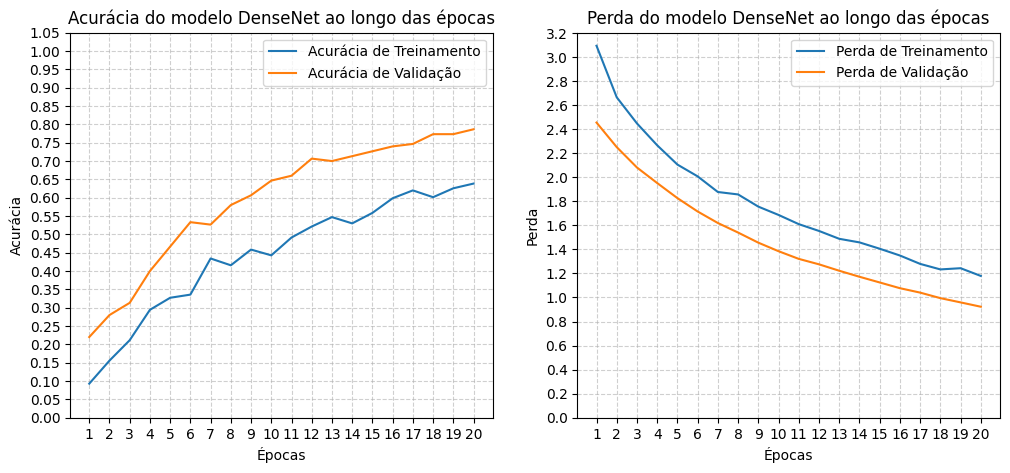

In [ ]:
# Plotando o gráfico
plt.figure(figsize=(12, 5))

# Gráfico de acurácia
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history_loaded_densenet['accuracy']) + 1), history_loaded_densenet['accuracy'], label='Acurácia de Treinamento')
plt.plot(range(1, len(history_loaded_densenet['val_accuracy']) + 1), history_loaded_densenet['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do modelo DenseNet ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(1, 21))
plt.yticks(ticks=np.arange(0, 1.1, 0.05))
plt.legend()

# Gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history_loaded_densenet['loss']) + 1), history_loaded_densenet['loss'], label='Perda de Treinamento')
plt.plot(range(1, len(history_loaded_densenet['val_loss']) + 1), history_loaded_densenet['val_loss'], label='Perda de Validação')
plt.title('Perda do modelo DenseNet ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(1, 21))
plt.yticks(ticks=np.arange(0, 3.4, 0.2))
plt.legend()

plt.show()

#### 6.3.3.2 - Matriz de confusão do modelo

5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7800 - loss: 0.8966
Test Accuracy DenseNet: 78.67%
Test Loss DenseNet: 90.26%
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step


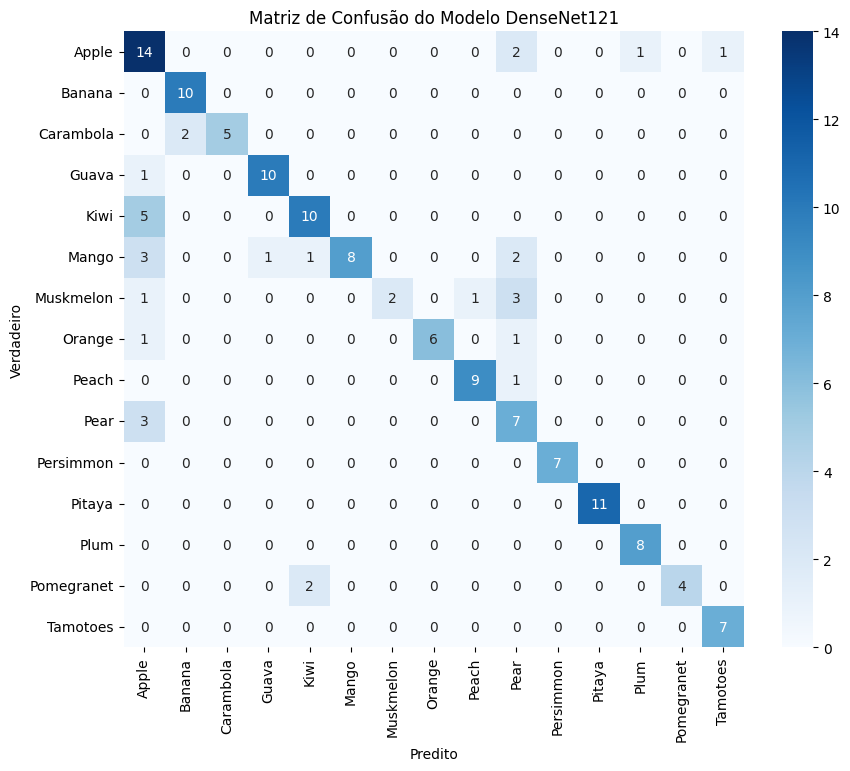

In [ ]:
test_loss_densenet, test_accuracy_densenet = model_loaded_densenet.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy DenseNet: {test_accuracy_densenet*100:.2f}%")
print(f"Test Loss DenseNet: {test_loss_densenet*100:.2f}%")

# 1. Obter as previsões para o conjunto de teste
y_pred_encoded_densenet = model_loaded_densenet.predict(X_test)
y_pred_densenet = np.argmax(y_pred_encoded_densenet, axis=1)  # Obter o índice com a maior probabilidade

# 2. Decodificar as previsões e os rótulos verdadeiros
y_test_decoded_densenet = np.argmax(y_test_encoded, axis=1)

# 3. Criar a matriz de confusão
conf_matrix_densenet = confusion_matrix(y_test_decoded_densenet, y_pred_densenet)

# 4. Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_densenet, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_encoder.categories_[0], yticklabels=one_hot_encoder.categories_[0])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão do Modelo DenseNet121')
plt.show()

#### 6.3.3.3 - Métricas Precision, Recall e F1-Score

In [ ]:
print(classification_report(y_test_decoded_densenet, y_pred_densenet, target_names=one_hot_encoder.categories_[0]))

              precision    recall  f1-score   support

       Apple       0.50      0.78      0.61        18
      Banana       0.83      1.00      0.91        10
   Carambola       1.00      0.71      0.83         7
       Guava       0.91      0.91      0.91        11
        Kiwi       0.77      0.67      0.71        15
       Mango       1.00      0.53      0.70        15
   Muskmelon       1.00      0.29      0.44         7
      Orange       1.00      0.75      0.86         8
       Peach       0.90      0.90      0.90        10
        Pear       0.44      0.70      0.54        10
   Persimmon       1.00      1.00      1.00         7
      Pitaya       1.00      1.00      1.00        11
        Plum       0.89      1.00      0.94         8
  Pomegranet       1.00      0.67      0.80         6
    Tamotoes       0.88      1.00      0.93         7

    accuracy                           0.79       150
   macro avg       0.87      0.79      0.81       150
weighted avg       0.84   

In [ ]:
print('Matriz de confusão (DenseNet): \n')
print(conf_matrix_densenet)

Matriz de confusão (DenseNet): 

[[14  0  0  0  0  0  0  0  0  2  0  0  1  0  1]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  1  1  8  0  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  2  0  1  3  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  6  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  1  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  7]]


#### 6.3.3.4 - Análises

- Gráficos de acurácia e perda:

* * Treinamento:

A acurácia de treino iniciou em 8,48% e alcançou 65,06% na última época. A perda de treino diminuiu bastante, indo de 3,1694 para 1,1455. Ambas tiveram um progresso uniforme, com pouquíssimas oscilações.

* * Validação:

A acurácia de validação começou em 22% e atingiu 78,67%, mostrando um crescimento constante e com poucas oscilações. A perda de validação caiu de 2,4548 para 0,9231. Semelhante ao treino, também apresentou um progresso com poucas oscilações.

* * Overfitting:

A diferença entre as acurácias de treino e validação na última época (65,06% e 78,67) é pequena, o que indica que o modelo está generalizando bem e não mostra sinais de overfitting. A redução consistente em ambas as perdas indica que o modelo está aprendendo bem a fazer as classificações.

- Matriz de Confusão

Na matriz de confusão vemos um desempenho relativamente bom, com algumas classes tendo uma excelente taxa de acerto, e outras ainda sendo confundidas. Banana, Persimmon, Pitaya, Plum e Tamotoes tiveram 100% de acerto; Guava e Peach também tiveram a maioria dos exemplos acertados.

Muskmelon continua com um desempenho muito baixo, assim como todos os outros modelos apresentados. Mango também teve muitos erros.

- Métricas de Avaliação:

Com as métricas reafirmamos o que constatamos na matriz de confusão, com Banana, Guava, Persimmon, Pitaya, Peach, Plum e Tamotoes com alto Recall e boa Precision, ou seja, tiveram alta taxa de acerto e foram confudidas por outras frutas em poucas ocasiões.

Apple e Pear tiveram uma precision baixa, ou seja, o modelo "chutou" que outras frutas eram essas em muitos casos.

- Conclusão:

O modelo teve uma boa evolução de aprendizado, com a acurácia subindo constantemente sem oscilações e pouca diferença quando comparado com a acurácia de validação, indicando que não há overfitting. O mesmo para a perda, que diminuiu de forma consistente, ou seja, o modelo está está aprendendo bem.

Apesar do modelo ainda possuir dificuldades com as classes Muskmelon e Pear, foi o que apresentou o melhor desempenho dos 4 com os dados de teste, com 78,67% de acurácia. Além disso, ele não apresenta sinais de overfitting (como no primeiro modelo) e obteve menos oscilações de acurácia e perda durante o treinamento do modelo.

# 7. Comparação de modelos e considerações finais
---

Após analisar os quatro modelos, vemos que o terceiro obteve um desempenho muito ruim, sendo descartado rapidamente para escolha do melhor modelo. O primeiro modelo obteve bons resultados, porém observamos que ele possuía overfitting, ou seja, seu desempenho estava alto pois ele estava decorando as imagens ao invés de aprender suas características, portanto vamos descartá-lo já que podemos ter resultados enganosos se usarmos esse modelo.

Ficamos com a disputa final entre o segundo e o quarto modelo. Ambos tiveram um desempenho semelhante, porém a segundo modelo apresentou muita oscilação durante o treinamento, como vimos nos gráficos de acurácia e perda. Além disso, obtivemos um acurácia com os dados de teste maior com o quarto modelo (78,67%) comparado com o segundo (74,67%), além de uma taxa maior de acertos quando vemos a matriz de confusão de ambos.

Dessa forma, iremos escolher o quarto modelo, DenseNet, como a melhor escolha.

Vale ressaltar que, apesar da escolha, o modelo ainda pode ser melhorado, principalmente em sua fase inicial. Aumentar o dataset, principalmente para as classes com menos imagens, seria uma boa ideia, visto que algumas dessa classes, como Muskmelon, tiveram um Recall baixo para o modelo escolhido.

Outra ideia seria diversificar mais o dataset. Inicialmente usamos como premissa o uso de imagens que pudessem simular o ambiente de uma bancada de mercado, então todas elas estão em uma bandeja de aluminío cinza. Talvez isso ajude no treinamento do modelo para esse cenário, porém caso o modelo precise ser usado em outros contexto, ele pode estar enviesado demais e perder o poder de generalização.

Aumentar a qualidade visual das imagens também é válido. Com isso o modelo poderia capturar melhor as características únicas das classes que possuem maior dificuldades de aprendizado.

Outras formas de melhorar o modelo seriam:
- Usar técnicas diferentes de otimização de hiperparâmetros, como GridSearchCV ou RandomizedSearchCV;
- Aumentar o leque de opções para os hiperparâmetros que seriam otimizados;
- Aumentar o número de épocas de treinamento.

Essas opções eram possíveis de se fazer nesse projeto, porém preferimos deixar essas opções limitadas devido ao tempo de processamento maior que eles levariam.